# **Imports**

In [ ]:
#!pip install optuna

In [132]:
import pandas as pd
import numpy as np
import optuna
from matplotlib import pyplot as plt
import seaborn as sns
import re
import random
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy.stats import randint
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import warnings
warnings.filterwarnings("ignore")

# **Data Simulation**

## *Step 1: Simulating Batch Data*

In [6]:
# Set random seed for reproducibility
np.random.seed(39)

# Number of batches
num_batches = 1000

# Generating batch start times (assuming a new batch starts every 3-10 hours)
start_times = [datetime(2025, 1, 1, 0, 0)]  # Start on Jan 1, 2025
for i in range(1, num_batches):
    start_times.append(start_times[-1] + timedelta(minutes=np.random.uniform(180, 600)))

# Generate batch compositions reflecting city waste
plastic_ratio = np.random.uniform(0.2, 0.5, num_batches)  # City-like plastic proportion
biomass_ratio = np.random.uniform(0.3, 0.7, num_batches)  # Higher biomass content
metal_ratio = np.random.uniform(0.01, 0.15, num_batches)  # Smaller fraction of metals
e_waste_ratio = np.random.uniform(0.01, 0.1, num_batches)  # Small fraction for e-waste
other_waste_ratio = np.random.uniform(0.1, 0.3, num_batches)  # Reflecting other unprocessable waste

# Normalize ratios so total = 1
total_ratio = plastic_ratio + biomass_ratio + metal_ratio + e_waste_ratio + other_waste_ratio
plastic_ratio /= total_ratio
biomass_ratio /= total_ratio
metal_ratio /= total_ratio
e_waste_ratio /= total_ratio
other_waste_ratio /= total_ratio

# Estimate batch weights
batch_weights = (np.random.uniform(500, 1500, num_batches) +
                 plastic_ratio * np.random.uniform(200, 500, num_batches) +
                 biomass_ratio * np.random.uniform(100, 300, num_batches) +
                 metal_ratio * np.random.uniform(400, 800, num_batches))

# Moisture after drying (target ≤ 10%) while taking into account waste composition
moisture = np.clip(biomass_ratio * np.random.uniform(0.05, 0.1) +  # Biomass retains most moisture
                         plastic_ratio * np.random.uniform(0.01, 0.03) + 
                         metal_ratio * np.random.uniform(0.005, 0.02) + 
                         other_waste_ratio * np.random.uniform(0.02, 0.06), 0.02, 0.1)

# Estimate processing times based on composition and weight
processing_durations = (plastic_ratio * np.random.uniform(120, 240, num_batches) + 
                        biomass_ratio * np.random.uniform(240, 480, num_batches) + 
                        metal_ratio * np.random.uniform(300, 540, num_batches) +
                        e_waste_ratio * np.random.uniform(360, 600, num_batches) +
                        other_waste_ratio * np.random.uniform(60, 180, num_batches)) * (batch_weights / 1000)

# Add random noise to processing durations and clip to a reasonable range
processing_durations += np.random.uniform(-10, 10, num_batches)
processing_durations = np.clip(processing_durations, 120, 480)  # Keep durations between 120-480 minutes

# Generating end times
end_times = [start + timedelta(minutes=duration) for start, duration in zip(start_times, processing_durations)]

# Classify batches based on dominant component
batch_types = []
for p, b, m, e, o in zip(plastic_ratio, biomass_ratio, metal_ratio, e_waste_ratio, other_waste_ratio):
    max_ratio = max(p, b, m, e, o)
    if max_ratio == p:
        batch_types.append("Plastic-Heavy")
    elif max_ratio == b:
        batch_types.append("Biomass-Heavy")
    elif max_ratio == m:
        batch_types.append("Metal-Heavy")
    elif max_ratio == e:
        batch_types.append("E-Waste-Heavy")
    else:
        batch_types.append("Mixed-Heavy")

# Create DataFrame
batch_df = pd.DataFrame({
    "Batch_ID": range(1, num_batches + 1),
    "Processing_Duration_mins": processing_durations,
    "Batch_Weight_kg": batch_weights,
    "Plastic_Ratio": plastic_ratio,
    "Biomass_Ratio": biomass_ratio,
    "Metal_Content": metal_ratio,
    "E_Waste_Ratio": e_waste_ratio,
    "Other_Waste_Ratio": other_waste_ratio,
    "Moisture_Content": moisture,
    "Batch_Type": batch_types,
    "Start_Time": start_times,
    "End_Time": end_times,
})

batch_df.head()

# Saving to CSV
#batch_df.to_csv("Batch_Info.csv", index=False)

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0         1                205.282694       954.007669       0.351385   
1         2                210.628787       875.867023       0.276741   
2         3                226.358838      1005.710567       0.312986   
3         4                290.045327      1040.628311       0.293665   
4         5                404.306189      1341.435590       0.198641   

   Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0       0.398791       0.043138       0.041557           0.165130   
1       0.408360       0.045983       0.057500           0.211415   
2       0.379118       0.080260       0.032466           0.195169   
3       0.354917       0.115617       0.076219           0.159583   
4       0.467661       0.069915       0.051911           0.211871   

   Moisture_Content     Batch_Type                 Start_Time  \
0          0.044198  Biomass-Heavy 2025-01-01 00:00:00.000000   
1          0.046327  Biomass-Heavy 2025-01-01 06:49:41.606735   
2          0.044292  Biomass-Heavy 2025-01-01 15:24:48.662071   
3          0.041120  Biomass-Heavy 2025-01-02 00:09:22.789444   
4          0.050573  Biomass-Heavy 2025-01-02 04:00:38.446088   

                    End_Time  
0 2025-01-01 03:25:16.961645  
1 2025-01-01 10:20:19.333972  
2 2025-01-01 19:11:10.192363  
3 2025-01-02 04:59:25.509091  
4 2025-01-02 10:44:56.817438

### Scientific Justification:
The waste composition ratios used in this model are based on typical urban waste profiles, as outlined in studies such as Wilson et al. (2015) and Zhang et al. (2018). These sources indicate that plastic content in municipal solid waste varies between 20-50%, biomass (including food and yard waste) ranges from 30-70%, and metals and e-waste make up small but significant fractions. 

The processing time estimations are derived from empirical data found in pyrolysis and thermal decomposition research (Anuar Sharuddin et al., 2016; Lopez et al., 2017). Higher biomass content generally increases processing time due to moisture content and complex organic structures, while plastic-dominant batches tend to decompose faster under high temperatures.

Additionally, the moisture content constraints align with guidelines in industrial pyrolysis operations, where a maximum moisture level of 10% is recommended for optimal efficiency (Mastral & Callen, 2000). 

## *Step 2: Simulating Sensor Data*
### Scientific References:
 - Depolymerization pressure dynamics: [Singh et al., 2020, Journal of Thermal Analysis and Calorimetry]
 - Influence of moisture and biomass on pyrolysis pressure: [Zhang et al., 2019, Energy & Fuels]
 - Temperature profiles for mixed-waste pyrolysis: [Wang et al., 2021, Renewable Energy]
 - pH variations in thermal decomposition processes: [Chen et al., 2018, Chemical Engineering Journal]
 - Syngas and oil yield factors from plastic-biomass mixtures: [Gupta & Basu, 2017, Fuel Processing Technology]

In [9]:
def simulate_pressure(biomass_ratio, e_waste_ratio, plastic_ratio, moisture, duration_mins, temperature_profile):
    pressure = np.zeros(duration_mins)
    phase1_duration = int(duration_mins * 0.2)  # Preheating phase
    phase2_duration = int(duration_mins * 0.35)  # Main gas production phase
    operational_phase_duration = duration_mins - (phase1_duration + phase2_duration)

    # Set the base pressure to 1 bar (starting condition)
    base_pressure = 1.0

    # Adjusting pressure contribution from moisture (higher moisture increases initial pressure buildup)
    moisture_pressure_factor = moisture * np.random.uniform(0.5, 1.0)

    # Initial phase: Pressure buildup due to initial heating and moisture evaporation
    pressure[:phase1_duration] = np.linspace(base_pressure, base_pressure + 0.5 + moisture_pressure_factor, phase1_duration)

    # Main depolymerization phase: Start smoothly from the last pressure of phase 1
    start_pressure = pressure[phase1_duration - 1]

    # Controlled waste contribution and moisture influence for a realistic pressure peak
    waste_contribution = (biomass_ratio * np.random.uniform(0.8, 1.2) +
                          e_waste_ratio * np.random.uniform(0.5, 1.0) +
                          plastic_ratio * np.random.uniform(0.2, 0.6))

    # Moisture influence on pressure during depolymerization
    moisture_depolymerization_effect = moisture * np.random.uniform(0.3, 0.6)

    # Faster pressure increase during depolymerization phase
    depolymerization_ramp_duration = phase2_duration // 2  # Faster rise than during phase 1
    depolymerization_ramp = np.linspace(start_pressure, start_pressure + waste_contribution + moisture_depolymerization_effect + 1.5, depolymerization_ramp_duration)
    pressure[phase1_duration:phase1_duration + depolymerization_ramp_duration] = depolymerization_ramp

    # Stabilization phase: Pressure plateaus with minor fluctuations
    stabilization_start = phase1_duration + depolymerization_ramp_duration
    target_pressure = pressure[stabilization_start - 1]  # Final pressure before stabilization
    pressure[stabilization_start:] = np.random.normal(loc=target_pressure, scale=0.15, size=duration_mins - stabilization_start)

    return pressure

def simulate_temperature(plastic_ratio, biomass_ratio, e_waste_ratio, moisture, duration_mins):
    temperature = np.zeros(duration_mins)
    
    # Set base target temperatures influenced by waste composition
    base_temp = 450 + plastic_ratio * np.random.uniform(30, 50) - biomass_ratio * np.random.uniform(10, 25) + e_waste_ratio * np.random.uniform(5, 15)
    
    # Set batch-dependent target temperatures for different phases
    target_temp_phase1 = np.random.uniform(300, 350)  # End of initial heating phase
    target_temp_phase2 = np.random.uniform(base_temp - 20, base_temp + 50)  # Final operating temperature influenced by waste
    
    # Adjust heating rates based on moisture content (higher moisture slows initial heating)
    moisture_slowdown_factor = 1 + (moisture / 10)  # Scale effect based on moisture content (10% max effect)

    heating_rate_phase1 = np.random.uniform(5, 10) / moisture_slowdown_factor  # Reduced initial heating rate (°C/min)
    heating_rate_phase2 = np.random.uniform(10, 15)  # Second heating phase rate (°C/min) is less affected by moisture
    
    # Duration for each heating phase
    phase1_duration = int((target_temp_phase1 - 50) / heating_rate_phase1)
    phase2_duration = int((target_temp_phase2 - target_temp_phase1) / heating_rate_phase2)
    
    # Remaining time for stabilization
    stabilization_start = phase1_duration + phase2_duration
    stabilization_duration = duration_mins - stabilization_start
    
    # Apply temperature profile
    temperature[:phase1_duration] = np.linspace(25, target_temp_phase1, phase1_duration)  # Phase 1 (slow heating due to moisture)
    temperature[phase1_duration:stabilization_start] = np.linspace(target_temp_phase1, target_temp_phase2, phase2_duration)  # Phase 2
    temperature[stabilization_start:] = np.random.normal(loc=target_temp_phase2, scale=10, size=stabilization_duration)  # Steady phase

    return temperature

def simulate_ph(biomass_ratio, plastic_ratio, metal_content, e_waste_ratio, other_waste_ratio, moisture, duration_mins):
    # Base pH influenced by waste composition
    baseline_ph = 7 - (1.5 * biomass_ratio) - (0.5 * e_waste_ratio) - (0.7 * metal_content) + (0.3 * other_waste_ratio)
    
    # Moisture effect on pH: Higher moisture decreases pH (acid formation during biomass breakdown)
    moisture_effect = -2 * moisture  # A 10% moisture level would reduce the base pH by 0.2 units
    
    # Apply the moisture adjustment to baseline pH
    adjusted_baseline_ph = baseline_ph + moisture_effect
    
    # Simulate time-dependent pH fluctuations
    pH_values = np.random.normal(loc=adjusted_baseline_ph, scale=0.5, size=duration_mins)
    
    return np.clip(pH_values, 4, 9)  # Limit pH within a realistic range for the reactor

def simulate_oil_and_syngas_flow(batch_weight, plastic_ratio, biomass_ratio, e_waste_ratio, moisture, duration_mins, temperature_profile):
    # Scientific conversion rates for oil and syngas based on waste composition and weight
    # Adjust oil yield downward and syngas yield slightly upward due to moisture
    oil_yield_per_kg = (plastic_ratio * np.random.uniform(0.6, 0.8) +
                        biomass_ratio * np.random.uniform(0.1, 0.4) +
                        e_waste_ratio * np.random.uniform(0.15, 0.35)) * (1 - 0.5 * moisture)  # Moisture reduces oil yield

    syngas_yield_per_kg = (biomass_ratio * np.random.uniform(0.4, 0.8) +
                           plastic_ratio * np.random.uniform(0.1, 0.3) +
                           e_waste_ratio * np.random.uniform(0.2, 0.5)) * (1 + 0.1 * moisture)  # Moisture slightly increases syngas

    # Calculating total oil and syngas production
    total_oil_yield = batch_weight * oil_yield_per_kg  # Total liters of oil
    total_syngas_yield = batch_weight * syngas_yield_per_kg  # Total cubic meters of syngas

    # Setting up time-dependent flow rates (ramp-up, steady, and shutdown phases)
    ramp_up_duration = int(duration_mins * 0.3)  # 30% of duration for ramp-up
    steady_duration = duration_mins - ramp_up_duration - int(duration_mins * 0.1)  # Last 10% for final stage where flow is lower

    # Oil flow rate with temperature and moisture-dependent scaling
    oil_flow_rate = np.zeros(duration_mins)
    for t in range(duration_mins):
        if temperature_profile[t] >= 300:
            scaling_factor = min((temperature_profile[t] - 300) / 200, 1.0)  # Temperature effect on oil flow
            moisture_penalty = 1 - 0.3 * moisture  # Moisture reduces peak oil flow during steady operation
            oil_flow_rate[t] = (total_oil_yield / duration_mins) * scaling_factor * moisture_penalty

    # Syngas flow rate with temperature and moisture-dependent scaling
    syngas_flow_rate = np.zeros(duration_mins)
    for t in range(duration_mins):
        if temperature_profile[t] >= 200:
            scaling_factor = min((temperature_profile[t] - 200) / 300, 1.0)  # Temperature effect on syngas flow
            moisture_boost = 1 + 0.05 * moisture  # Slight boost in syngas flow due to water vapor
            syngas_flow_rate[t] = (total_syngas_yield / duration_mins) * scaling_factor * moisture_boost

    return oil_flow_rate, syngas_flow_rate

def add_drift(sensor_readings, drift_magnitude=0.02):
    drift = np.cumsum(np.random.uniform(-drift_magnitude, drift_magnitude, len(sensor_readings)))  # Gradual drift
    
    return sensor_readings + drift

def simulate_waste_input_flow (batch_weight, duration_mins, loading_fraction=0.07):
    # Calculating loading duration as a fraction of total duration
    loading_duration = int(duration_mins * loading_fraction)
    # Calculating the base flow rate
    base_flow_rate = batch_weight / loading_duration
    # Initializing flow rate array with some variability, ensuring total doesn't exceed batch weight
    flow_rate = np.random.normal(loc=base_flow_rate, scale=0.1 * base_flow_rate, size=loading_duration)
    flow_rate = np.clip(flow_rate, 0.8 * base_flow_rate, 1.2 * base_flow_rate)  # Limit variability to +/- 20%
    # Normalize flow rate to ensure total weight is exactly the batch weight
    flow_rate *= batch_weight / np.sum(flow_rate)
    
    # Initialize flow array for the entire duration
    waste_flow_array = np.zeros(duration_mins)  # Renamed this variable
    waste_flow_array[:loading_duration] = flow_rate  # Set flow rates during loading phase
    return waste_flow_array

def introduce_random_spikes(sensor_data, spike_fraction=0.01, spike_magnitude=(20, 50)):
    num_rows = len(sensor_data)
    spike_indices = np.random.choice(num_rows, size=int(spike_fraction * num_rows), replace=False)

    # Adding spikes to temperature, pressure, and pH levels
    sensor_data.loc[spike_indices, "Temperature"] += np.random.uniform(*spike_magnitude, len(spike_indices)) # Moderate spikes in temperature
    sensor_data.loc[spike_indices, "Pressure"] += np.random.uniform(0.5, 1.5, len(spike_indices))  # Moderate spikes in pressure
    sensor_data.loc[spike_indices, "pH_Level"] += np.random.uniform(-1.5, 1.5, len(spike_indices))  # Small spikes in pH
    sensor_data.loc[spike_indices, "Stirring_Speed"] += np.random.uniform(-30, 30, len(spike_indices)) # Moderate spikes in stirring speed

    return sensor_data

def introduce_sensor_malfunctions(sensor_data, malfunction_fraction=0.005):
    num_rows = len(sensor_data)
    malfunction_indices = np.random.choice(num_rows, size=int(malfunction_fraction * num_rows), replace=False)

    # Randomly select which sensor feature to set as NaN
    for i in malfunction_indices:
        feature_to_null = np.random.choice(["Temperature", "Pressure", "pH_Level", "Stirring_Speed"])
        sensor_data.loc[i, feature_to_null] = np.nan  # Introduce missing value

    return sensor_data

In [10]:
sensor_data_list = []

for i in range(len(batch_df)):
    batch = batch_df.iloc[i]
    start_time = pd.to_datetime(batch["Start_Time"])
    duration_mins = int(batch["Processing_Duration_mins"])
    time_series = pd.date_range(start=start_time, periods=duration_mins, freq='T')

    # Temperature and pressure simulations 
    temperature = simulate_temperature(batch["Plastic_Ratio"], batch["Biomass_Ratio"], batch["E_Waste_Ratio"], batch["Moisture_Content"], duration_mins)
    pressure = simulate_pressure(batch["Biomass_Ratio"], batch["E_Waste_Ratio"], batch["Plastic_Ratio"], batch["Moisture_Content"], duration_mins, temperature)

    stirring_speed = np.random.normal(loc=200, scale=20, size=duration_mins)
    pH_level = simulate_ph(batch["Biomass_Ratio"], batch["Plastic_Ratio"], batch["Metal_Content"], 
                           batch["E_Waste_Ratio"], batch["Other_Waste_Ratio"], batch["Moisture_Content"], duration_mins)
    
    # Adjusting waste input flow with variability, ensuring total batch weight is met
    waste_input_flow = simulate_waste_input_flow(batch["Batch_Weight_kg"], duration_mins)
    
    # Calculating oil and syngas flow rates based on composition, weight, and temperature
    oil_flow_rate, syngas_flow_rate = simulate_oil_and_syngas_flow(
        batch["Batch_Weight_kg"], batch["Plastic_Ratio"], batch["Biomass_Ratio"], batch["E_Waste_Ratio"], batch["Moisture_Content"], duration_mins, temperature
    )
    
    off_calibrated_temp = add_drift(temperature, drift_magnitude=0.05)
    off_calibrated_pressure = add_drift(pressure, drift_magnitude=0.01)

    if np.random.rand() > 0.95:
        anomaly_index = np.random.randint(0, duration_mins // 2)
        off_calibrated_temp[anomaly_index:anomaly_index + 5] += np.random.uniform(20, 50)
    
    if np.random.rand() > 0.95:
        pH_level[np.random.randint(0, duration_mins)] += np.random.choice([-2, 2])
    
    batch_sensor_data = pd.DataFrame({
        "Batch_ID": batch["Batch_ID"],
        "Elapsed_Time": (time_series - time_series.min()).total_seconds() / 60,  # Convert to minutes
        "Temperature": off_calibrated_temp,
        "Pressure": off_calibrated_pressure,
        "Stirring_Speed": stirring_speed,
        "pH_Level": pH_level,
        "Waste_Input_Flow_Rate": waste_input_flow,
        "Oil_Flow_Rate": oil_flow_rate,
        "Syngas_Flow_Rate": syngas_flow_rate
    })

    # Introducing spikes and malfunctions to sensor data to simulate realistic conditions
    batch_sensor_data = introduce_random_spikes(batch_sensor_data)
    batch_sensor_data = introduce_sensor_malfunctions(batch_sensor_data)
 
    sensor_data_list.append(batch_sensor_data)

# Combining all sensor data into a single DataFrame
all_sensor_data = pd.concat(sensor_data_list, ignore_index=True)

# Saving to CSV
#all_sensor_data.to_csv("Sensors.csv", index=False)

all_sensor_data.head()

Batch_ID  Elapsed_Time  Temperature  Pressure  Stirring_Speed  pH_Level  \
0         1           0.0    25.020652  1.008337      212.027616  5.962387   
1         1           1.0    34.075272  1.015320      155.271982  5.944598   
2         1           2.0    43.113903  1.034568      180.129455  6.239572   
3         1           3.0    52.106819  1.054165      167.330017  6.337298   
4         1           4.0    61.075043  1.073828      204.160395  6.251641   

   Waste_Input_Flow_Rate  Oil_Flow_Rate  Syngas_Flow_Rate  
0              77.306138            0.0               0.0  
1              78.806121            0.0               0.0  
2              66.351360            0.0               0.0  
3              63.051520            0.0               0.0  
4              65.590712            0.0               0.0

## *Step 3: Simulating Yield and Purity*
This function estimates the oil yield and purity from thermal depolymerization units (TDU) by considering 
sensor data and batch composition. The calculations are based on established principles of pyrolysis, 
the impact of moisture and contaminants, and the effects of temperature and pressure on reaction efficiency.
    
### Scientific Rationale:
    1. Exclusion of Heating Phase: The heating phase is removed from analysis since initial warming 
       does not contribute significantly to oil production (LeBreton et al., 2019).
    2. Oil Volume Calculation: The integral of oil flow rate over time provides the total oil yield 
       (Yuan et al., 2021). Moisture content negatively impacts yield, as water vapor competes with 
       pyrolysis reactions (Zhao et al., 2020).
    3. Contamination Impact on Purity:
       - Biomass contributes solid residues and oxygenated compounds, reducing oil purity (Bridgwater, 2012).
       - E-waste introduces halogenated and heavy-metal contaminants (Zhou et al., 2022).
       - Metals oxidize and promote catalytic cracking side reactions, increasing impurities (Mani et al., 2009).
    4. Temperature and Pressure Corrections:
       - Higher temperatures enhance cracking efficiency, reducing impurity formation (Demirbas, 2009).
       - Increased pressure promotes heavier hydrocarbon formation, affecting purity (Dai et al., 2023).

In [12]:
def calculate_oil_yield_and_purity(batch_df, all_sensor_data, heating_phase_fraction=0.2):
    oil_volumes = []
    oil_purities = []
    batch_ids = []
    
    for batch_id in batch_df["Batch_ID"].unique():
        # Retrieving data for the specific batch
        batch = batch_df[batch_df["Batch_ID"] == batch_id].iloc[0]
        batch_sensors = all_sensor_data[all_sensor_data["Batch_ID"] == batch_id]
        
        # Excluding data from the heating phase
        total_duration = len(batch_sensors)
        processing_start = int(total_duration * heating_phase_fraction)
        processing_sensors = batch_sensors.iloc[processing_start:]
        
        # Calculating the total oil volume (integral of oil flow rate)
        oil_volume = processing_sensors["Oil_Flow_Rate"].sum() 

        # Retrieving moisture level for the batch
        moisture_level = batch["Moisture_Content"]  # Assuming this column exists in `batch_df`

        # Adjusting oil yield based on moisture content (higher moisture reduces yield)
        effective_oil_volume = oil_volume * (1 - moisture_level)  # Linearly reducing oil yield

        # Batch composition ratios
        plastic_ratio = batch["Plastic_Ratio"]
        biomass_ratio = batch["Biomass_Ratio"]
        e_waste_ratio = batch["E_Waste_Ratio"]
        metal_content = batch["Metal_Content"]
        
        # Average temperature and pressure during processing
        avg_temperature = processing_sensors["Temperature"].mean()
        avg_pressure = processing_sensors["Pressure"].mean()

        # Contamination coefficients
        k_biomass = 20  # Biomass lowers purity due to moisture and solid residues
        k_e_waste = 10  # E-waste introduces toxins
        k_metal = 15  # Metals cause contamination through oxidation

        # Base impurity based on batch composition
        base_impurity = biomass_ratio * k_biomass + e_waste_ratio * k_e_waste + metal_content * k_metal

        # Purity correction based on temperature, pressure, and moisture level
        temp_correction = max(0, (avg_temperature - 300) / 100)  # Higher temperature improves purity
        pressure_correction = min(5, avg_pressure / 2)  # Higher pressure also improves purity
        moisture_penalty = moisture_level * 10  # Higher moisture reduces purity by up to 10% (adjustable)

        # Final oil purity in the range 0-100%
        oil_purity = 100 - base_impurity + temp_correction + pressure_correction - moisture_penalty
        oil_purity = max(0, min(100, oil_purity))  # Ensure purity is between 0 and 100%

        # Appending results to lists
        batch_ids.append(batch_id)
        oil_volumes.append(effective_oil_volume)
        oil_purities.append(oil_purity)

    # Creating a new DataFrame to log oil yields and purities
    yield_log_df = pd.DataFrame({
        "Batch_ID": batch_ids,
        "Oil_Volume_Liters": oil_volumes,
        "Oil_Purity_Percent": oil_purities
    })
    
    return yield_log_df

# Calculating the yield log with moisture considerations
YieldLog = calculate_oil_yield_and_purity(batch_df, all_sensor_data)

#Saving to CSV
#YieldLog.to_csv("YieldLog.csv", index=False)

# First few rows of the simulated yield logs
YieldLog.head()

Batch_ID  Oil_Volume_Liters  Oil_Purity_Percent
0         1         280.051643           94.188621
1         2         164.763444           93.333601
2         3         203.510352           93.993437
3         4         175.142590           93.221601
4         5         186.885345           91.812728

# **Initial Overview of the Data**

#### *Note*:
Since the data was simulated earlier, we already have a significant understanding of what to expect and where most issues could arise, in this case it would primarily be related to the sensor data. With this in mind, all standard steps that would normally be part of the data exploration and cleaning will still be employed, though the main focus and attention will be placed on the problematic areas of the data to avoid artifical and unnecessary bloating of the notebook

## *Step 1: Checking Batch Data*

In [16]:
batch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Batch_ID                  1000 non-null   int64         
 1   Processing_Duration_mins  1000 non-null   float64       
 2   Batch_Weight_kg           1000 non-null   float64       
 3   Plastic_Ratio             1000 non-null   float64       
 4   Biomass_Ratio             1000 non-null   float64       
 5   Metal_Content             1000 non-null   float64       
 6   E_Waste_Ratio             1000 non-null   float64       
 7   Other_Waste_Ratio         1000 non-null   float64       
 8   Moisture_Content          1000 non-null   float64       
 9   Batch_Type                1000 non-null   object        
 10  Start_Time                1000 non-null   datetime64[ns]
 11  End_Time                  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](2),

In [17]:
batch_df.describe()

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
count  1000.000000               1000.000000      1000.000000    1000.000000   
mean    500.500000                337.477858      1228.318022       0.292519   
min       1.000000                152.804613       657.648350       0.156757   
25%     250.750000                269.656415       990.964073       0.245177   
50%     500.500000                337.158444      1228.324471       0.291784   
75%     750.250000                409.751790      1465.449736       0.338987   
max    1000.000000                480.000000      1817.126569       0.471979   
std     288.819436                 86.373330       286.290856       0.063962   

       Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
count    1000.000000    1000.000000    1000.000000        1000.000000   
mean        0.420936       0.069917       0.047680           0.168947   
min         0.254039       0.007773       0.007619           0.078189   
25%         0.367829       0.042796       0.028920           0.131318   
50%         0.421812       0.070634       0.047201           0.167739   
75%         0.470165       0.095052       0.064350           0.206023   
max         0.639988       0.165529       0.115763           0.327282   
std         0.070080       0.033123       0.022453           0.048196   

       Moisture_Content                     Start_Time  \
count       1000.000000                           1000   
mean           0.045938  2025-05-19 09:47:57.872652288   
min            0.034569            2025-01-01 00:00:00   
25%            0.042656  2025-03-11 00:34:36.634457600   
50%            0.045987  2025-05-19 09:35:21.704236288   
75%            0.049037  2025-07-27 19:01:36.167381760   
max            0.058377     2025-10-03 01:33:03.780431   
std            0.004371                            NaN   

                            End_Time  
count                           1000  
mean   2025-05-19 15:25:26.544125696  
min       2025-01-01 03:25:16.961645  
25%    2025-03-11 08:14:14.575861760  
50%    2025-05-19 13:24:56.544758016  
75%    2025-07-27 23:39:09.543116032  
max       2025-10-03 07:22:47.004812  
std                              NaN

From the initial overview, we see that the variability throughout all parameters of the dataset except moisture content is quite high, which is a good thing in this case as it will allow more room for experimentation with the features for model training, such as training on different batch types, or the data only to batches with a certain threshold of plastic/biowaste ratios, though it will depend on the findings of the exploratory data analysis.

## *Step 2: Checking Sensor Data*

#### *Note:*
As each parameter is measured through different units of measurement, they are outlined below for context:

    Temperate - Degrees Celcius (°C)
    Pressure - Bar
    Stirring_Speed - Revolutions Per Minute (RPM)
    Waste_Input_Flow_Rate - Kilograms Per Minute (kg/m)
    Oil_Flow_Rate - Liters Per Minute (l/m)
    Syngas_Flow_Rate - Cubic Meters Per Minute (m³/m)

In [21]:
all_sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337024 entries, 0 to 337023
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Batch_ID               337024 non-null  int64  
 1   Elapsed_Time           337024 non-null  float64
 2   Temperature            336735 non-null  float64
 3   Pressure               336709 non-null  float64
 4   Stirring_Speed         336713 non-null  float64
 5   pH_Level               336709 non-null  float64
 6   Waste_Input_Flow_Rate  337024 non-null  float64
 7   Oil_Flow_Rate          337024 non-null  float64
 8   Syngas_Flow_Rate       337024 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 23.1 MB


We can immediately see that the sensor data contains null values (it was simulated to do so, but still), so this will definitely require cleaning as it may affect model performance

In [23]:
all_sensor_data.describe()

Batch_ID   Elapsed_Time    Temperature       Pressure  \
count  337024.000000  337024.000000  336735.000000  336709.000000   
mean      498.522426     179.084860     434.992048       2.980717   
std       290.120960     114.466396     100.334545       0.987164   
min         1.000000       0.000000      24.950046       0.986350   
25%       246.000000      84.000000     442.758403       2.156865   
50%       502.000000     168.000000     464.938908       3.476911   
75%       749.000000     261.000000     484.925662       3.676085   
max      1000.000000     479.000000     574.595226       5.606376   

       Stirring_Speed       pH_Level  Waste_Input_Flow_Rate  Oil_Flow_Rate  \
count   336713.000000  336709.000000          337024.000000  337024.000000   
mean       200.020376       6.249008               3.644601       0.835317   
std         20.074530       0.518634              13.619245       0.386686   
min        109.002404       3.192704               0.000000       0.000000   
25%        186.542246       5.899792               0.000000       0.685271   
50%        200.072654       6.249183               0.000000       0.873587   
75%        213.532474       6.596665               0.000000       1.082943   
max        295.719228       9.120844              94.856359       2.046928   

       Syngas_Flow_Rate  
count     337024.000000  
mean           0.957356  
std            0.384562  
min            0.000000  
25%            0.819057  
50%            0.997046  
75%            1.198479  
max            2.032351

From the overview we can see that, much like the batch data, there is significant variability in the sensor data, though it is much less obvious as to how "dirty" the data is when taking into account the initial loading and heating process, which will have much lower sensor readings than during the active depolymerization process

For a more insightful overview, it makes sense to check the sensor data without taking into account the loading and heating phases as it will allow to see the variability throughout the most crucial part - active depolymerization

In [25]:
# Filter the data to include only rows where the temperature is 300°C or more, as that temperature will include the start of - 
# both plastic and biomass depolymerization, thereby avoiding data from the heating phase for batches with higher start points
main_depolymerization_data = all_sensor_data[all_sensor_data["Temperature"] >= 300]

main_depolymerization_data.describe()

Batch_ID   Elapsed_Time    Temperature       Pressure  \
count  302692.000000  302692.000000  302692.000000  302408.000000   
mean      498.410245     197.281573     465.855521       3.185794   
std       290.334406     106.225483      32.394941       0.816073   
min         1.000000      21.000000     300.019041       1.090067   
25%       246.000000     109.000000     450.177390       3.062964   
50%       502.000000     185.000000     469.019384       3.521952   
75%       749.000000     272.000000     487.004356       3.696088   
max      1000.000000     479.000000     574.595226       5.606376   

       Stirring_Speed       pH_Level  Waste_Input_Flow_Rate  Oil_Flow_Rate  \
count   302419.000000  302403.000000          302692.000000  302692.000000   
mean       200.016168       6.248220               0.069192       0.929269   
std         20.073620       0.519090               1.858100       0.281130   
min        109.002404       3.192704               0.000000       0.000000   
25%        186.546914       5.897952               0.000000       0.751572   
50%        200.068792       6.248187               0.000000       0.909035   
75%        213.531493       6.596085               0.000000       1.108338   
max        295.719228       9.120844              71.504920       2.046928   

       Syngas_Flow_Rate  
count     302692.000000  
mean           1.056960  
std            0.254444  
min            0.164233  
25%            0.882934  
50%            1.033535  
75%            1.228520  
max            2.032351

Now with a more accurate picture of the data, we can see that the average amounts for each feature is in accordance to standard TDU proccess readings, however, it is also evident that major outliers are present in the sensor readings, so they will need to be adjusted/cleaned (in accordance to standard TDU process readings) for optimal model performance

## *Step 3: Checking Yield Data*

In [28]:
YieldLog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Batch_ID            1000 non-null   int64  
 1   Oil_Volume_Liters   1000 non-null   float64
 2   Oil_Purity_Percent  1000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [29]:
YieldLog.describe()

Batch_ID  Oil_Volume_Liters  Oil_Purity_Percent
count  1000.000000        1000.000000         1000.000000
mean    500.500000         245.768012           92.993217
std     288.819436          82.134961            1.411835
min       1.000000          84.604197           89.146829
25%     250.750000         186.340227           91.961068
50%     500.500000         234.516404           92.903808
75%     750.250000         298.701446           93.934373
max    1000.000000         529.738992           96.744957

The average volume of the oil looks promissing, however the minimum volume being 63.5l raises questions, so the batch composition and its respective sensor data will need to be checked to determine whether it is an outlier or if the volume is justified.

As for the purity, the data looks optimistic with minimal variations

# **Data Cleaning and Exploratory Data Analysis**

## Step 1: Dealing with Null Values in Sensor Data

Considering the Null values represent momentary sensor failure, the best approach would be to substitute the Null values with information based on the nearest sensor readings before and after the Null, as it would be representative of the changes in all relevant parameters (temperature, pressure, pH, stirring speed) without accidentally introducing anomalies like sudden spikes, which would either way be handled later

In [33]:
def fill_null_values_with_average(sensor_data, columns_to_fill):
    """
    Function designed to fill null values in the specified columns of the sensor data using the average of the 
    nearest non-null values before and after the null.
    
    Parameters:
    sensor_data (pd.DataFrame): DataFrame containing sensor data with potential null values.
    columns_to_fill (list): List of column names to apply the fill logic to.

    Returns:
    pd.DataFrame: Sensor data with null values replaced.
    """
    # Creating a copy of the DataFrame so as to avoid overwriting the initial data, which could be used as a reference point
    filled_data = sensor_data.copy()

    for column in columns_to_fill:
        # Finding indices of null values
        null_indices = filled_data[filled_data[column].isna()].index

        for idx in null_indices:
            # Finding nearest previous and next non-null values
            prev_idx = filled_data[column][:idx].last_valid_index()
            next_idx = filled_data[column][idx:].first_valid_index()

            # Calculating the average of the nearest valid values
            if prev_idx is not None and next_idx is not None: #To avoid crashes, checking whether there is at least some sensor data
                avg_value = (filled_data.at[prev_idx, column] + filled_data.at[next_idx, column]) / 2
            elif prev_idx is not None:
                # If only a previous value exists
                avg_value = filled_data.at[prev_idx, column]
            elif next_idx is not None:
                # If only a next value exists
                avg_value = filled_data.at[next_idx, column]
            else:
                # If no valid values are found, leave it as NaN (fallback case)
                avg_value = np.nan

            # Filling the current null value with the calculated average
            filled_data.at[idx, column] = avg_value

    return filled_data

#List of columns can be expanded depending on the presence of null values in the data
filled_sensor_data = fill_null_values_with_average(all_sensor_data, ["Temperature", "Pressure", "pH_Level", "Stirring_Speed"])

In [34]:
filled_sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337024 entries, 0 to 337023
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Batch_ID               337024 non-null  int64  
 1   Elapsed_Time           337024 non-null  float64
 2   Temperature            337024 non-null  float64
 3   Pressure               337024 non-null  float64
 4   Stirring_Speed         337024 non-null  float64
 5   pH_Level               337024 non-null  float64
 6   Waste_Input_Flow_Rate  337024 non-null  float64
 7   Oil_Flow_Rate          337024 non-null  float64
 8   Syngas_Flow_Rate       337024 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 23.1 MB


As we can see, all Null values have been taken care of, which means we can proceed to handling anomalies, outliers, and otherwise questionable data

## Step 2: Sensor Data Cleaning

### 2.1: Temperature Data Cleaning

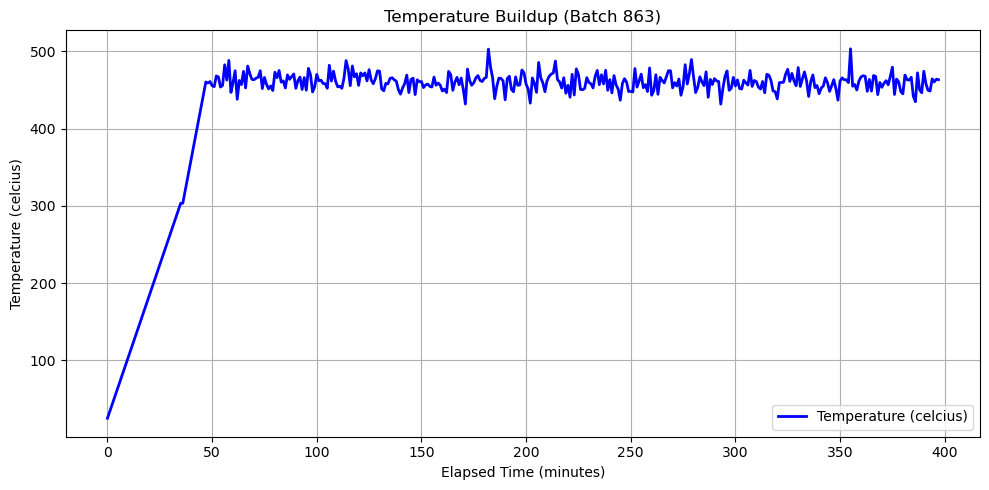

In [38]:
# Visualizing the temperature readings for a random batch as a starting point to check cleaning results
selected_batch_id = 863
selected_batch_data = filled_sensor_data[filled_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Temperature"], label='Temperature (celcius)', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Temperature Buildup (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Temperature (celcius)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
def clean_temperature_by_batch(sensor_data, temp_change_threshold=20):
    cleaned_batches = []  # Store cleaned batch data

    # Loop through each batch
    for batch_id in sensor_data["Batch_ID"].unique():
        batch_data = sensor_data[sensor_data["Batch_ID"] == batch_id].copy()
        cleaned_temperatures = batch_data["Temperature"].values 

        for i in range(1, len(cleaned_temperatures) - 1):
            prev_temp = cleaned_temperatures[i - 1]
            curr_temp = cleaned_temperatures[i]
            next_temp = cleaned_temperatures[i + 1]

            # Detecting sudden temperature change higher than the temperature change threshold
            if abs(curr_temp - prev_temp) > temp_change_threshold:
                # Correcting the temperature using neighboring valid readings
                if abs(next_temp - prev_temp) <= temp_change_threshold:
                    cleaned_temperatures[i] = (prev_temp + next_temp) / 2  # Average neighbors
                elif abs(prev_temp - curr_temp) <= temp_change_threshold:
                    cleaned_temperatures[i] = prev_temp  # Fallback to previous valid reading
                elif abs(next_temp - curr_temp) <= temp_change_threshold:
                    cleaned_temperatures[i] = next_temp  # Fallback to next valid reading
                else:
                    cleaned_temperatures[i] = prev_temp  # Default fallback to previous reading

        # Replacing the original temperature column with the cleaned temperatures
        batch_data["Temperature"] = cleaned_temperatures

        # Store the cleaned batch data
        cleaned_batches.append(batch_data)

    # Combining all cleaned batches into a new df
    cleaned_sensor_data = pd.concat(cleaned_batches, ignore_index=True)
    
    return cleaned_sensor_data

cleaned_sensor_data = clean_temperature_by_batch(filled_sensor_data)
cleaned_sensor_data.head()


Batch_ID  Elapsed_Time  Temperature  Pressure  Stirring_Speed  pH_Level  \
0         1           0.0    25.020652  1.008337      212.027616  5.962387   
1         1           1.0    34.075272  1.015320      155.271982  5.944598   
2         1           2.0    43.113903  1.034568      180.129455  6.239572   
3         1           3.0    52.106819  1.054165      167.330017  6.337298   
4         1           4.0    61.075043  1.073828      204.160395  6.251641   

   Waste_Input_Flow_Rate  Oil_Flow_Rate  Syngas_Flow_Rate  
0              77.306138            0.0               0.0  
1              78.806121            0.0               0.0  
2              66.351360            0.0               0.0  
3              63.051520            0.0               0.0  
4              65.590712            0.0               0.0

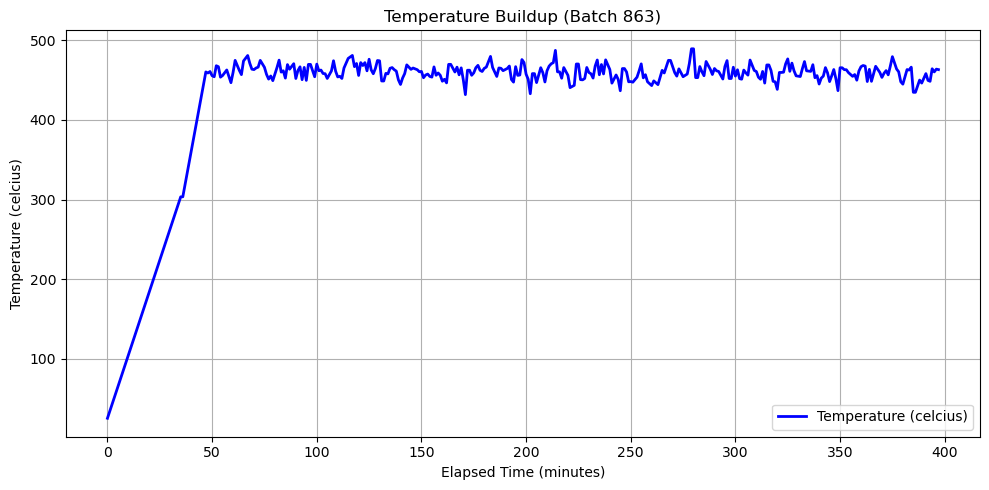

In [40]:
# Checking cleaning results
selected_batch_id = 863
selected_batch_data = cleaned_sensor_data[cleaned_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Temperature"], label='Temperature (celcius)', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Temperature Buildup (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Temperature (celcius)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, the most notable spikes in temperature have been smoothed out, which confirms that the function works as intended

### 2.2: Pressure Data Cleaning

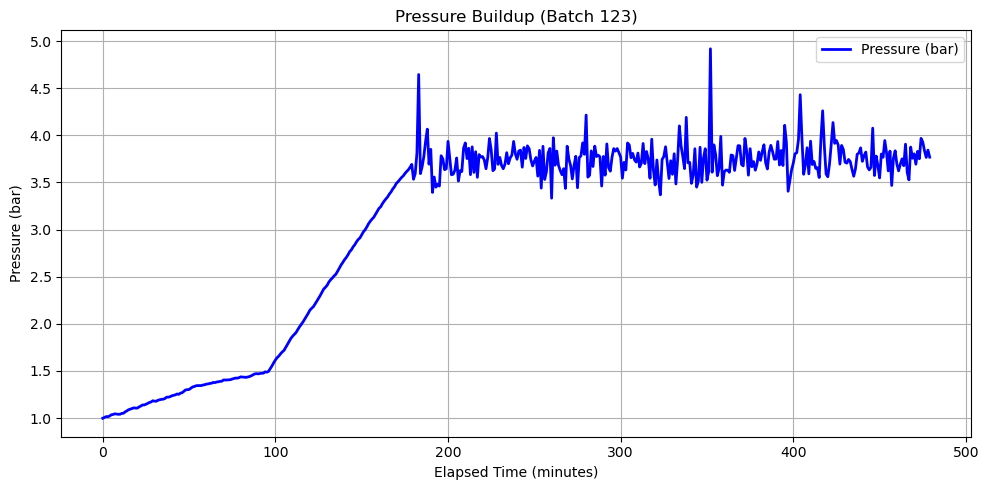

In [43]:
# Visualizing the pressure readings for a random batch as a starting point to check cleaning results
selected_batch_id = 123
selected_batch_data = filled_sensor_data[filled_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Pressure"], label='Pressure (bar)', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Pressure Buildup (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Pressure (bar)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

From the pressure readings of the chosen batch we can see several significant spikes in pressure, especially during the initial heating phase, which would suggest that the reason lies in sensor malfunctions

In [45]:
def clean_pressure_by_batch(sensor_data, pressure_change_threshold=0.75, valid_pressure_range=(1, 5)):
    cleaned_batches = []  # Store cleaned batch data
    
    # Loop through each batch
    for batch_id in sensor_data["Batch_ID"].unique():
        batch_data = sensor_data[sensor_data["Batch_ID"] == batch_id].copy()
        cleaned_pressures = batch_data["Pressure"].values  # Access as a NumPy array for easy indexing

        for i in range(1, len(cleaned_pressures) - 1):
            prev_pressure = cleaned_pressures[i - 1]
            curr_pressure = cleaned_pressures[i]
            next_pressure = cleaned_pressures[i + 1]

            # Detect sudden pressure changes or out-of-range values
            if (abs(curr_pressure - prev_pressure) > pressure_change_threshold or
                curr_pressure < valid_pressure_range[0] or curr_pressure > valid_pressure_range[1]):
                
                # Correct the pressure using neighboring valid readings
                if abs(next_pressure - prev_pressure) <= pressure_change_threshold:
                    cleaned_pressures[i] = (prev_pressure + next_pressure) / 2  # Average neighbors
                elif abs(prev_pressure - curr_pressure) <= pressure_change_threshold:
                    cleaned_pressures[i] = prev_pressure  # Fallback to previous valid reading
                elif abs(next_pressure - curr_pressure) <= pressure_change_threshold:
                    cleaned_pressures[i] = next_pressure  # Fallback to next valid reading
                else:
                    cleaned_pressures[i] = prev_pressure  # Default fallback to previous reading

        # Replace the original pressure column with the cleaned pressures
        batch_data["Pressure"] = cleaned_pressures

        # Store the cleaned batch data
        cleaned_batches.append(batch_data)

    # Combine all cleaned batches into a new DataFrame
    cleaned_sensor_data = pd.concat(cleaned_batches, ignore_index=True)
    
    return cleaned_sensor_data

# Usage
cleaned_sensor_data = clean_pressure_by_batch(cleaned_sensor_data)
cleaned_sensor_data.head()

Batch_ID  Elapsed_Time  Temperature  Pressure  Stirring_Speed  pH_Level  \
0         1           0.0    25.020652  1.008337      212.027616  5.962387   
1         1           1.0    34.075272  1.015320      155.271982  5.944598   
2         1           2.0    43.113903  1.034568      180.129455  6.239572   
3         1           3.0    52.106819  1.054165      167.330017  6.337298   
4         1           4.0    61.075043  1.073828      204.160395  6.251641   

   Waste_Input_Flow_Rate  Oil_Flow_Rate  Syngas_Flow_Rate  
0              77.306138            0.0               0.0  
1              78.806121            0.0               0.0  
2              66.351360            0.0               0.0  
3              63.051520            0.0               0.0  
4              65.590712            0.0               0.0

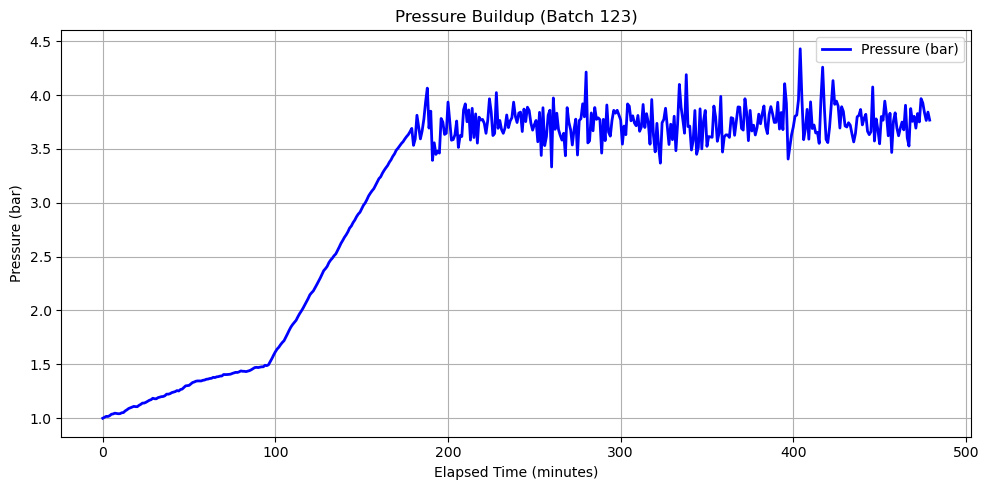

In [46]:
# Checking cleaning results
selected_batch_id = 123
selected_batch_data = cleaned_sensor_data[cleaned_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Pressure"], label='Pressure (bar)', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Pressure Buildup (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Pressure (bar)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As with the temperature cleaning, the primary causes for concern have been removed as intended

### 2.3: pH Data Cleaning

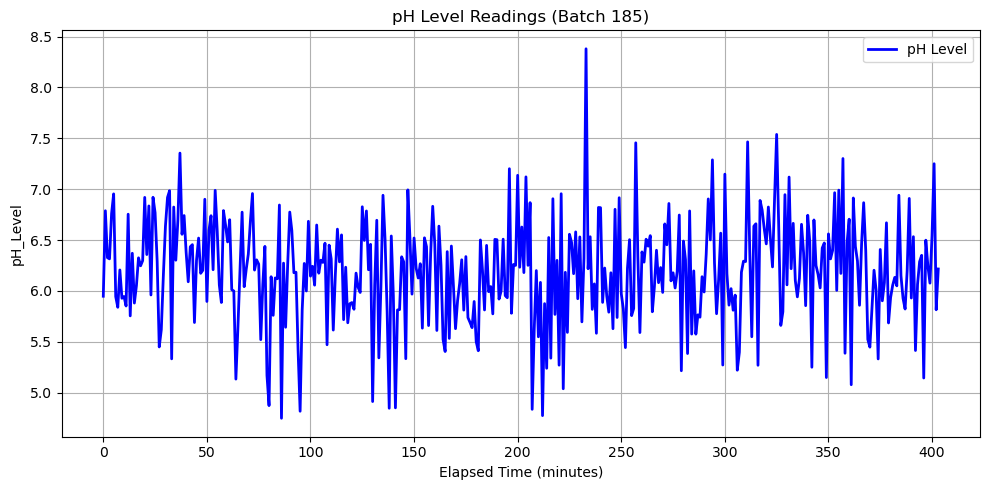

In [49]:
# Visualizing the pressure buildup for a random batch
selected_batch_id = 185
selected_batch_data = filled_sensor_data[filled_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["pH_Level"], label='pH Level', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'pH Level Readings (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('pH_Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
def clean_ph_data(sensor_data, trust_interval=(4.0, 7.5), ph_change_threshold=0.5):
    # Copy pH data for cleaning
    cleaned_ph = sensor_data["pH_Level"].copy()

    for i in range(1, len(cleaned_ph) - 1):
        prev_ph = cleaned_ph[i - 1]
        curr_ph = cleaned_ph[i]
        next_ph = cleaned_ph[i + 1]

        # Check for anomalies based on change rate or trust interval
        if abs(curr_ph - prev_ph) > ph_change_threshold or not (trust_interval[0] <= curr_ph <= trust_interval[1]):
            # Replace the anomaly using interpolation between previous and next values
            cleaned_ph[i] = (prev_ph + next_ph) / 2

    # Create a new DataFrame replacing the old pH column
    cleaned_sensor_data = sensor_data.copy()
    cleaned_sensor_data["pH_Level"] = cleaned_ph

    return cleaned_sensor_data

cleaned_sensor_data = clean_ph_data(cleaned_sensor_data)
cleaned_sensor_data.describe()

Batch_ID   Elapsed_Time    Temperature       Pressure  \
count  337024.000000  337024.000000  337024.000000  337024.000000   
mean      498.522426     179.084860     434.754461       2.973832   
std       290.120960     114.466396     100.210035       0.982879   
min         1.000000       0.000000      24.950046       0.987834   
25%       246.000000      84.000000     443.067957       2.142549   
50%       502.000000     168.000000     464.819249       3.475705   
75%       749.000000     261.000000     484.586362       3.673658   
max      1000.000000     479.000000     564.735750       5.189952   

       Stirring_Speed       pH_Level  Waste_Input_Flow_Rate  Oil_Flow_Rate  \
count   337024.000000  337024.000000          337024.000000  337024.000000   
mean       200.019439       6.247829               3.644601       0.835317   
std         20.070515       0.387870              13.619245       0.386686   
min        109.002404       4.203457               0.000000       0.000000   
25%        186.544936       5.986230               0.000000       0.685271   
50%        200.071419       6.248466               0.000000       0.873587   
75%        213.527641       6.509887               0.000000       1.082943   
max        295.719228       7.832729              94.856359       2.046928   

       Syngas_Flow_Rate  
count     337024.000000  
mean           0.957356  
std            0.384562  
min            0.000000  
25%            0.819057  
50%            0.997046  
75%            1.198479  
max            2.032351

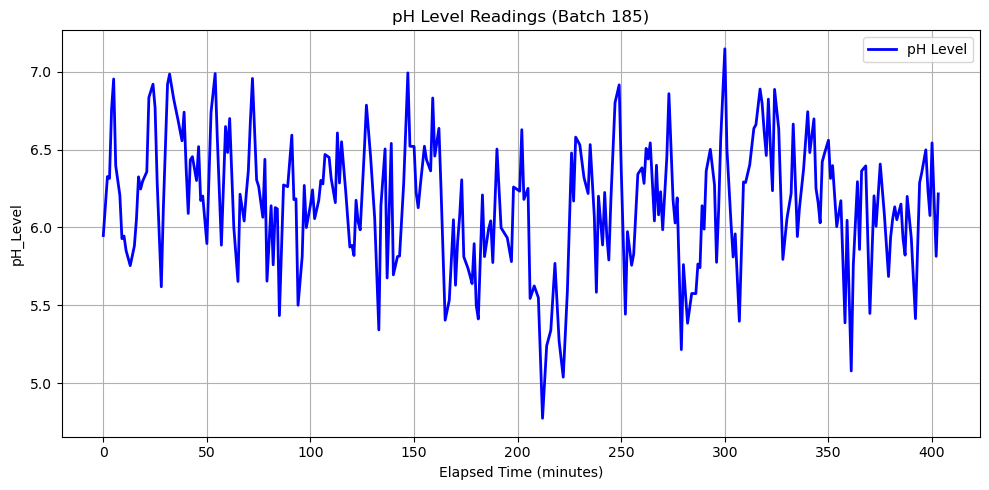

In [51]:
# Visualizing the pressure buildup for a random batch
selected_batch_id = 185
selected_batch_data = cleaned_sensor_data[cleaned_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["pH_Level"], label='pH Level', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'pH Level Readings (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('pH_Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can still see that pH level changes significantly throughout the process but much less erraticly than before and within the realistic ranges

### 2.4: Stirring Speed Data Cleaning

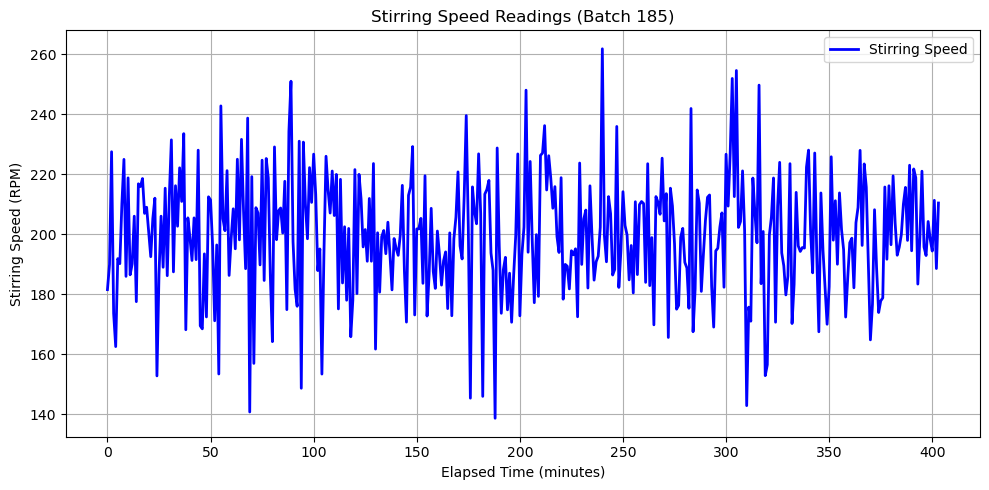

In [54]:
# Visualizing the pressure buildup for a random batch
selected_batch_id = 185
selected_batch_data = filled_sensor_data[filled_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Stirring_Speed"], label='Stirring Speed', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Stirring Speed Readings (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Stirring Speed (RPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
def clean_stirring_speed_data(sensor_data, trust_interval=(100, 400), speed_change_threshold=30):
    # Copy stirring speed data for cleaning
    cleaned_stirring_speed = sensor_data["Stirring_Speed"].copy()

    for i in range(1, len(cleaned_stirring_speed) - 1):
        prev_speed = cleaned_stirring_speed[i - 1]
        curr_speed = cleaned_stirring_speed[i]
        next_speed = cleaned_stirring_speed[i + 1]

        # Check for anomalies based on speed change rate or trust interval
        if abs(curr_speed - prev_speed) > speed_change_threshold or not (trust_interval[0] <= curr_speed <= trust_interval[1]):
            # Replace the anomaly using interpolation between previous and next values
            cleaned_stirring_speed[i] = (prev_speed + next_speed) / 2

    # Create a new DataFrame replacing the old Stirring_Speed column
    cleaned_sensor_data = sensor_data.copy()
    cleaned_sensor_data["Stirring_Speed"] = cleaned_stirring_speed

    return cleaned_sensor_data

# Example usage
cleaned_sensor_data = clean_stirring_speed_data(cleaned_sensor_data)
cleaned_sensor_data.describe()


Batch_ID   Elapsed_Time    Temperature       Pressure  \
count  337024.000000  337024.000000  337024.000000  337024.000000   
mean      498.522426     179.084860     434.754461       2.973832   
std       290.120960     114.466396     100.210035       0.982879   
min         1.000000       0.000000      24.950046       0.987834   
25%       246.000000      84.000000     443.067957       2.142549   
50%       502.000000     168.000000     464.819249       3.475705   
75%       749.000000     261.000000     484.586362       3.673658   
max      1000.000000     479.000000     564.735750       5.189952   

       Stirring_Speed       pH_Level  Waste_Input_Flow_Rate  Oil_Flow_Rate  \
count   337024.000000  337024.000000          337024.000000  337024.000000   
mean       200.087610       6.247829               3.644601       0.835317   
std         16.311062       0.387870              13.619245       0.386686   
min        120.810755       4.203457               0.000000       0.000000   
25%        188.996522       5.986230               0.000000       0.685271   
50%        200.105885       6.248466               0.000000       0.873587   
75%        211.209407       6.509887               0.000000       1.082943   
max        274.577158       7.832729              94.856359       2.046928   

       Syngas_Flow_Rate  
count     337024.000000  
mean           0.957356  
std            0.384562  
min            0.000000  
25%            0.819057  
50%            0.997046  
75%            1.198479  
max            2.032351

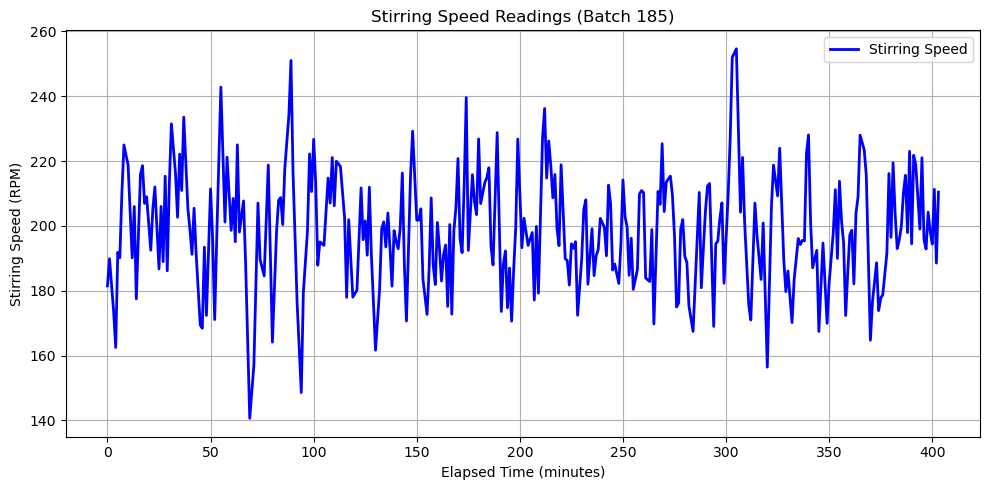

In [56]:
# Visualizing the pressure buildup for a random batch
selected_batch_id = 185
selected_batch_data = cleaned_sensor_data[cleaned_sensor_data["Batch_ID"] == selected_batch_id]

plt.figure(figsize=(10, 5))
plt.plot(selected_batch_data["Elapsed_Time"], selected_batch_data["Stirring_Speed"], label='Stirring Speed', color='blue', linewidth=2)

# Formatting the plot
plt.title(f'Stirring Speed Readings (Batch {selected_batch_id})')
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Stirring Speed (RPM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Same as with the pH level readings, much less fluctuation and lower peaks as a result of the data cleaning, as intended

### 2.5: Removing Batches with Anomalies in Average Temperature

Considering the standard TDU process parameters and their ranges, after checking the averages across all batches, anomalies were only found in the average temperature (those exceeding 500 degrees celcius despite the standard operating temperatures for Mixed-Waste TDUs being in the 380-500 range at the stage of main depolymerization, which has the highest temperature)

As such, these are the only anomalies which will need to be removed

In [60]:
def locate_and_remove_anomaly_temp_batches(sensor_data, batch_df, high_temp_threshold=500, low_temp_threshold=400):
    # Initialize a list to store batches with anomalous temperatures
    anomalous_batches = []

    # Group sensor data by Batch_ID
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Filter data to include only temperatures after 380 degrees is reached
        batch_data_after_380 = batch_data[batch_data["Temperature"] >= 380]

        # If valid readings exist after reaching 380 degrees, calculate average temperature
        if not batch_data_after_380.empty:
            avg_operating_temp = batch_data_after_380["Temperature"].mean()

            # Check if the average operating temperature exceeds thresholds
            if avg_operating_temp > high_temp_threshold or avg_operating_temp < low_temp_threshold:
                anomalous_batches.append((batch_id, avg_operating_temp))

    # Convert results to DataFrame for better readability
    anomaly_temp_batches = pd.DataFrame(anomalous_batches, columns=["Batch_ID", "Average_Operating_Temperature"])

    # Get list of Batch_IDs with anomalies
    anomalous_batch_ids = anomaly_temp_batches["Batch_ID"].unique()

    # Remove the anomalous batches from both sensor data and batch_df
    cleaned_sensor_data = sensor_data[~sensor_data["Batch_ID"].isin(anomalous_batch_ids)].reset_index(drop=True)
    cleaned_batch_df = batch_df[~batch_df["Batch_ID"].isin(anomalous_batch_ids)].reset_index(drop=True)

    return anomaly_temp_batches, cleaned_sensor_data, cleaned_batch_df

# Example usage
anomaly_temp_batches, cleaned_sensor_data, cleaned_batch_df = locate_and_remove_anomaly_temp_batches(cleaned_sensor_data, batch_df)

# Display results
print("Number of batches removed:", len(anomaly_temp_batches))
print("Remaining batches in cleaned_batch_df:", len(cleaned_batch_df))

Number of batches removed: 55
Remaining batches in cleaned_batch_df: 945


In [61]:
anomaly_temp_batches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Batch_ID                       55 non-null     int64  
 1   Average_Operating_Temperature  55 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1012.0 bytes


## Step 3: Exploratory Data Analysis

### 3.1: Batch Data Analysis + Relation to Yield Results

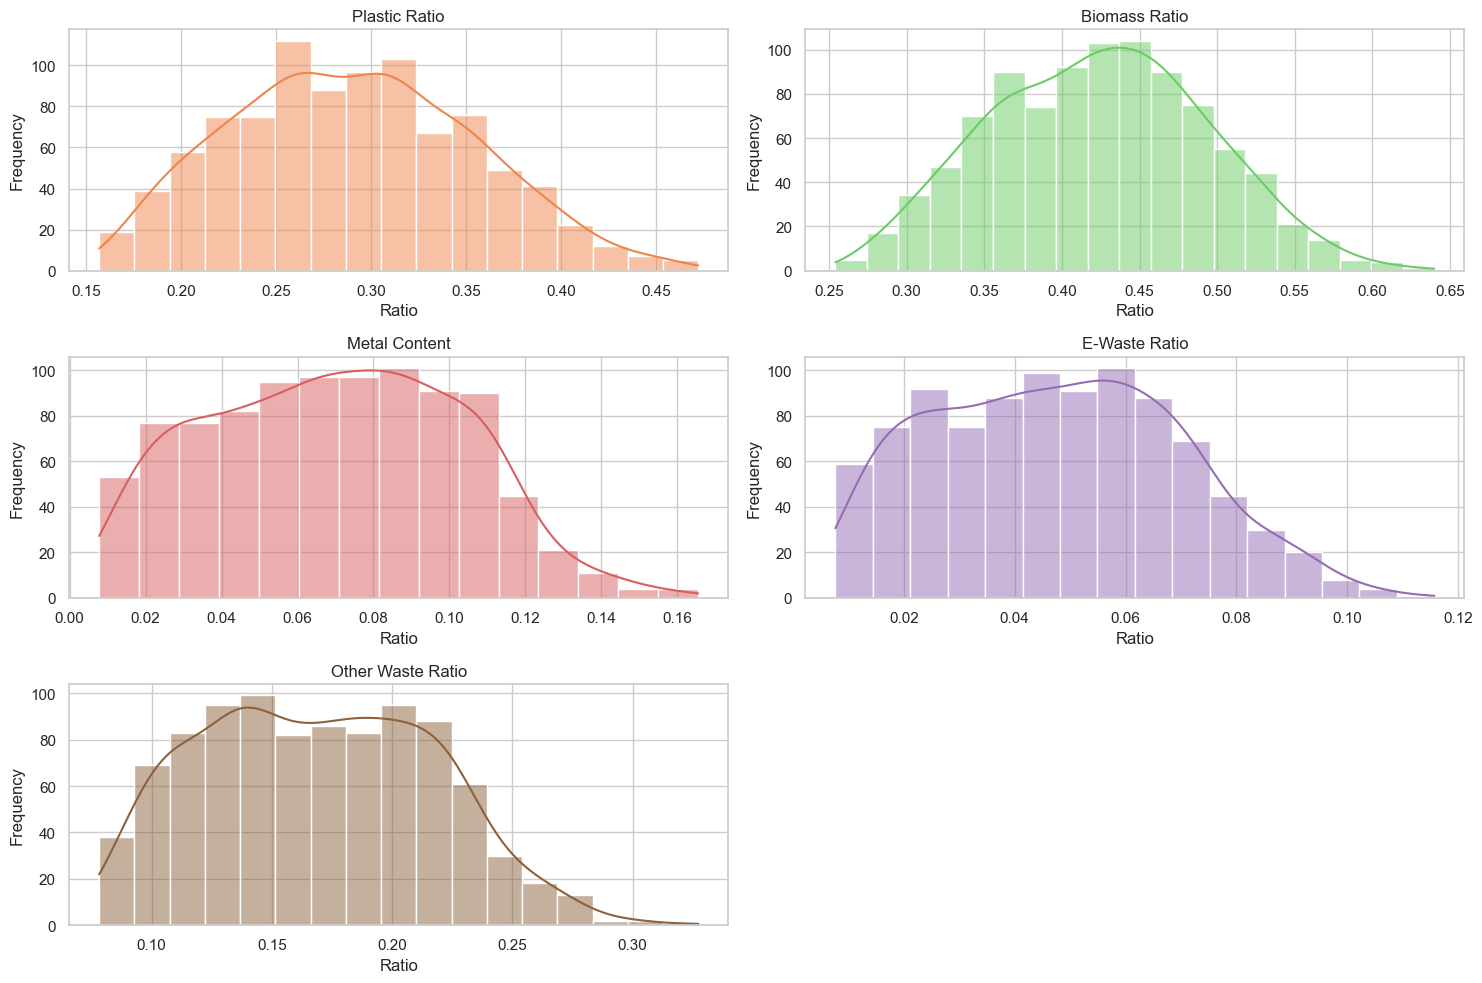

In [64]:
sns.set_theme(style="whitegrid", palette="muted")

waste_ratios = ["Plastic_Ratio", "Biomass_Ratio", "Metal_Content", "E_Waste_Ratio", "Other_Waste_Ratio"]
titles = ["Plastic Ratio", "Biomass Ratio", "Metal Content", "E-Waste Ratio", "Other Waste Ratio"]

plt.figure(figsize=(15, 10))
for i, (column, title) in enumerate(zip(waste_ratios, titles), 1):
    plt.subplot(3, 2, i)
    sns.histplot(cleaned_batch_df[column], kde=True, color=sns.color_palette("muted")[i % len(sns.color_palette("muted"))])
    plt.title(title)
    plt.xlabel("Ratio")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

As we can see from the graphs above, the **most predominant type of waste** in our batches is **Biomass**, which is in line with the common waste composition data from urban areas. Additionally, **Plastic** is also significantly present, the amount of which should have significant influence on the oil yield and purity

As for the other waste types, we can see that metal and e-waste are most commonly seen in the 3-10% and 2-6% ranges respectively, which may have an impact on oil yield and purity although not a majorly significant one. Other waste, on the other hand, is mainly present in the 13-23% range, as by our definition of Other waste it will not lead to any oil yield and will instead only take up batch space

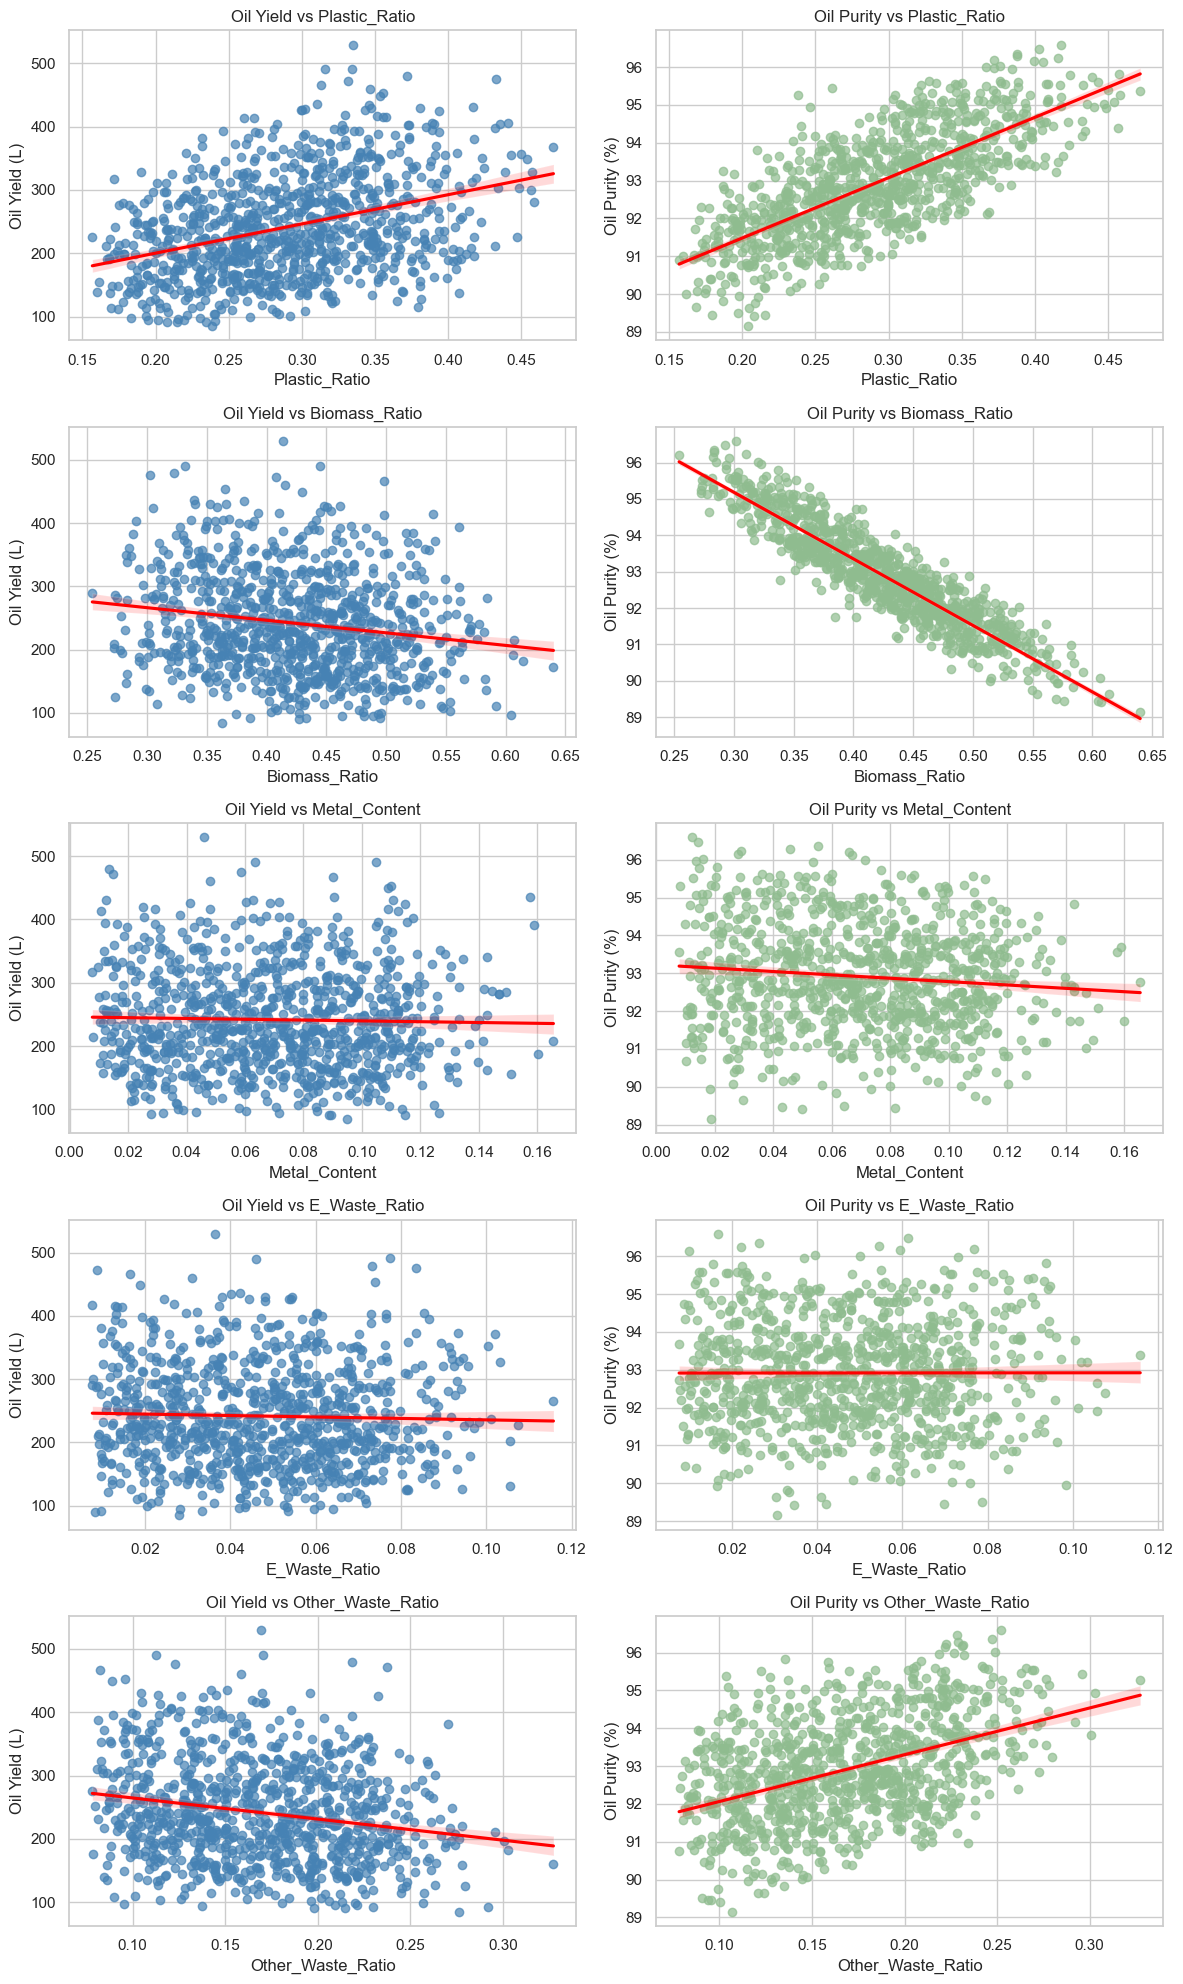

In [66]:
batch_and_yield_log = pd.merge(YieldLog, cleaned_batch_df, on="Batch_ID")

features = ["Plastic_Ratio", "Biomass_Ratio", "Metal_Content", "E_Waste_Ratio", "Other_Waste_Ratio"]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 20))

for i, feature in enumerate(features):
    sns.regplot(
        x=batch_and_yield_log[feature], y=batch_and_yield_log["Oil_Volume_Liters"],
        ax=axes[i, 0], scatter_kws={"alpha": 0.7, "color": "steelblue"}, line_kws={"color": "red"}
    )
    axes[i, 0].set_title(f"Oil Yield vs {feature}")
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Oil Yield (L)")
    
    sns.regplot(
        x=batch_and_yield_log[feature], y=batch_and_yield_log["Oil_Purity_Percent"],
        ax=axes[i, 1], scatter_kws={"alpha": 0.7, "color": "darkseagreen"}, line_kws={"color": "red"}
    )
    axes[i, 1].set_title(f"Oil Purity vs {feature}")
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Oil Purity (%)")

plt.tight_layout()
plt.show()

As we can see, the initial hypothesis regarding plastic having a positive impact on the oil yield and purity has been largely confirmed, seeing as there is a clear upwards trend in the oil volume and yield which correlates with the total plastic volume. To sum up the key insight from the visualisations above:

1 - Plastic Ratio has a **direct and evident correlation** with both oil yield and purity.

2 - Biomass Ratio, surprisingly, has a **slight negative correlation** with oil yield despite the same not being present with the Metal and E-waste ratios, which could be due to the much smaller presence of the latter 2 in the batches and the fact that higher presence of biomass would likely mean lower presence of plastic in the batch. Additionally, it has a **direct negative correlation** with oil purity, most likely due to the higher moisture content.

3 - While Metal Ratio has **very slight negative impact** on the oil yield, it has a **relevant negative impact** on the oil purity

4 - E-waste has **no notable impact** on neither the oil yield nor purity, which could, again, be due to it making up the smallest portion of total waste material on average

5 - Other Waste having a **negative impact** on oil yield is to be expected, considering that it makes up a relatively significant portion of the total waste material without leading to any increase in yield, however, It having a **significant positive impact** on the oil purity is interesting to say the least


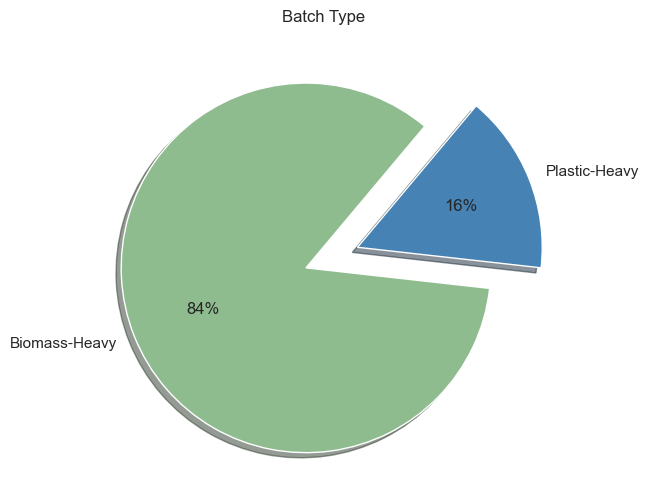

In [68]:
cleaned_batch_df['Batch_Type'].value_counts().plot(kind='pie',figsize=(6,6), autopct='%1.0f%%', colors = ['darkseagreen', 'steelblue'], \
             explode = [0.1,0.2], startangle=50,shadow=True, title='Batch Type')
plt.ylabel('')
plt.show()

Regarding the batch types, the distribution is somewhat expected, with the majority of the batches being biomass-heavy, though unfortunate that the are no metal-/e-waste-/mixed-heavy batches, as they could have provided interesting data

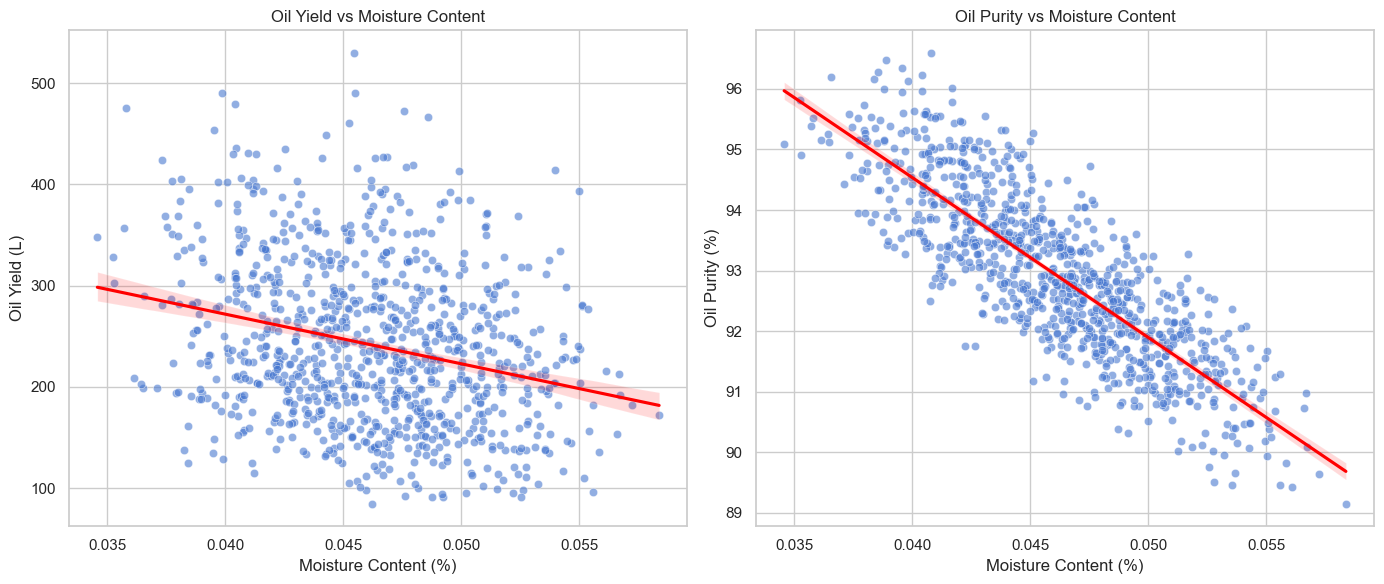

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=batch_and_yield_log["Moisture_Content"], y=batch_and_yield_log["Oil_Volume_Liters"], alpha=0.6, ax=axes[0])
sns.regplot(x=batch_and_yield_log["Moisture_Content"], y=batch_and_yield_log["Oil_Volume_Liters"], scatter=False, color="red", ax=axes[0])
axes[0].set_title("Oil Yield vs Moisture Content")
axes[0].set_xlabel("Moisture Content (%)")
axes[0].set_ylabel("Oil Yield (L)")

sns.scatterplot(x=batch_and_yield_log["Moisture_Content"], y=batch_and_yield_log["Oil_Purity_Percent"], alpha=0.6, ax=axes[1])
sns.regplot(x=batch_and_yield_log["Moisture_Content"], y=batch_and_yield_log["Oil_Purity_Percent"], scatter=False, color="red", ax=axes[1])
axes[1].set_title("Oil Purity vs Moisture Content")
axes[1].set_xlabel("Moisture Content (%)")
axes[1].set_ylabel("Oil Purity (%)")

plt.tight_layout()
plt.show()

Among my initial assumptions was that higher moisture content is detrimental to both oil purity on oil yield, which has been 
confirmed by the visualisation above, with moisture having an almost **1-to-1 negative correlation with purity**.

As for the correlation between moisture and oil yield, we can see that it is present and significant, though I expect it to be even higher than what we can see above when taking into account the total batch weight, as that would also be directly tied to the oil yield

In [72]:
#Adding oil/kg for further analysis
batch_and_yield_log['Oil_per_kg'] = batch_and_yield_log['Oil_Volume_Liters'] / batch_and_yield_log['Batch_Weight_kg']
batch_and_yield_log.head()

Batch_ID  Oil_Volume_Liters  Oil_Purity_Percent  Processing_Duration_mins  \
0         1         280.051643           94.188621                205.282694   
1         2         164.763444           93.333601                210.628787   
2         3         203.510352           93.993437                226.358838   
3         4         175.142590           93.221601                290.045327   
4         5         186.885345           91.812728                404.306189   

   Batch_Weight_kg  Plastic_Ratio  Biomass_Ratio  Metal_Content  \
0       954.007669       0.351385       0.398791       0.043138   
1       875.867023       0.276741       0.408360       0.045983   
2      1005.710567       0.312986       0.379118       0.080260   
3      1040.628311       0.293665       0.354917       0.115617   
4      1341.435590       0.198641       0.467661       0.069915   

   E_Waste_Ratio  Other_Waste_Ratio  Moisture_Content     Batch_Type  \
0       0.041557           0.165130          0.044198  Biomass-Heavy   
1       0.057500           0.211415          0.046327  Biomass-Heavy   
2       0.032466           0.195169          0.044292  Biomass-Heavy   
3       0.076219           0.159583          0.041120  Biomass-Heavy   
4       0.051911           0.211871          0.050573  Biomass-Heavy   

                  Start_Time                   End_Time  Oil_per_kg  
0 2025-01-01 00:00:00.000000 2025-01-01 03:25:16.961645    0.293553  
1 2025-01-01 06:49:41.606735 2025-01-01 10:20:19.333972    0.188115  
2 2025-01-01 15:24:48.662071 2025-01-01 19:11:10.192363    0.202355  
3 2025-01-02 00:09:22.789444 2025-01-02 04:59:25.509091    0.168305  
4 2025-01-02 04:00:38.446088 2025-01-02 10:44:56.817438    0.139317

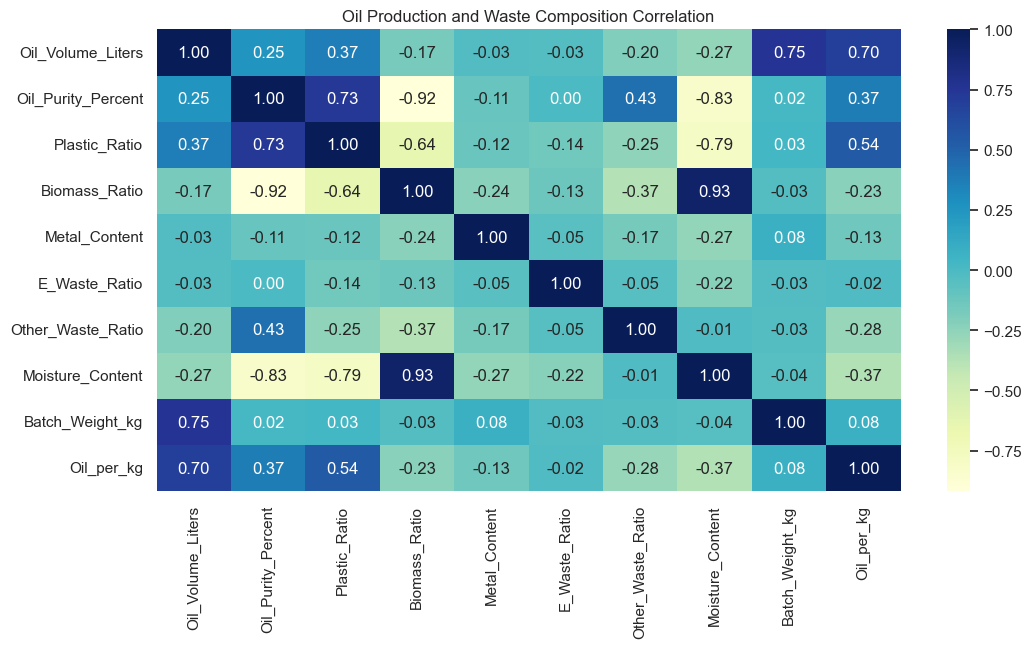

In [73]:
plt.figure(figsize=(12, 6))

corr_matrix = batch_and_yield_log[["Oil_Volume_Liters", "Oil_Purity_Percent", "Plastic_Ratio", "Biomass_Ratio", "Metal_Content", "E_Waste_Ratio", "Other_Waste_Ratio", "Moisture_Content", "Batch_Weight_kg", "Oil_per_kg"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Oil Production and Waste Composition Correlation")
plt.show()

While a correlation matrix is not the end-all-be-all in regards to seeing the entire picture of the data, seeing as it cannot directly show any non-linear correlations, we can still get some insights from it, especially when it comes to model training and understanding its future behaviour

Most of what we see matches up with what has been established previously, such as the biomass ratio and moisture content affecting oil purity (biomass directly affects moisture which explains the correlation quite well) and the plastic ratio affecting the final yield (oil/kg in this case)

### 3.2: Sensor Data Analysis

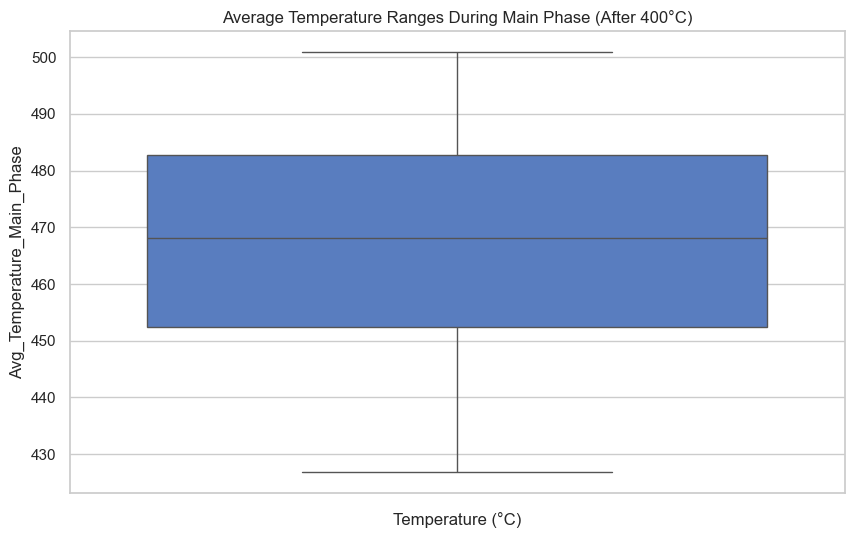

In [76]:
def calculate_main_phase_avg_temp(sensor_data):
    main_phase_temps = []

    # Group sensor data by Batch_ID
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Identify the start of the main phase (first instance where temperature reaches 400 degrees)
        main_phase_start = batch_data[batch_data["Temperature"] >= 400].index.min()

        if pd.notna(main_phase_start):  # Ensure there is a valid main phase start
            main_phase_data = batch_data.loc[main_phase_start:]
            avg_temp_main_phase = main_phase_data["Temperature"].mean()
            main_phase_temps.append((batch_id, avg_temp_main_phase))

    # Create a DataFrame for visualization
    main_phase_df = pd.DataFrame(main_phase_temps, columns=["Batch_ID", "Avg_Temperature_Main_Phase"])
    return main_phase_df

# Calculate the main phase temperature averages
main_phase_df = calculate_main_phase_avg_temp(cleaned_sensor_data)

# Plotting the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=main_phase_df["Avg_Temperature_Main_Phase"])
plt.title("Average Temperature Ranges During Main Phase (After 400°C)")
plt.xlabel("Temperature (°C)")
plt.show()


As we can see, most of our batches (2nd and 3rds quartiles) fall within the 450 - 480 range in terms of average temperature, which aligns with the standard TDU process parameters. The only point of suspicion is the outlier with the average temperature being higher ever so slightly higher than 500, but we also know that it is not a result of spikes and could be explained by the batch having a higher plastic content leading to the increase in temperature. Overall, the data is within acceptable ranges.

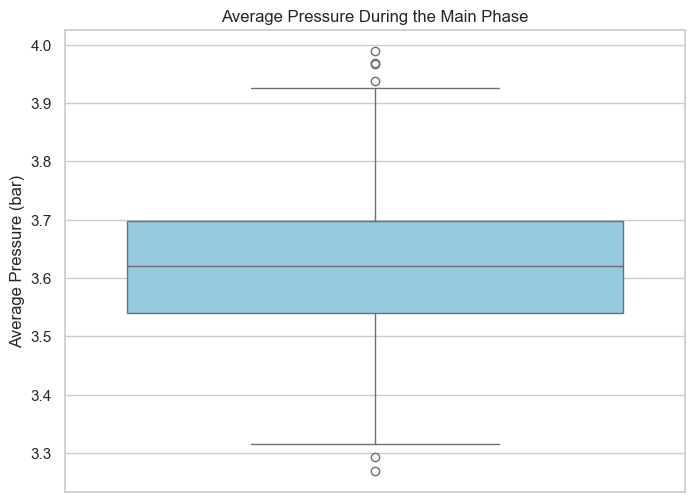

In [78]:
def calculate_main_phase_pressure(sensor_data):
    pressure_stats = []

    # Group data by Batch_ID
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Determine the start of the main phase (35% of duration)
        main_phase_start = int(0.35 * len(batch_data))
        main_phase_data = batch_data.iloc[main_phase_start:]

        # Calculate average pressure during the main phase
        avg_pressure = main_phase_data["Pressure"].mean()
        pressure_stats.append({"Batch_ID": batch_id, "Avg_Pressure": avg_pressure})

    # Create DataFrame with results
    pressure_df = pd.DataFrame(pressure_stats)
    return pressure_df

# Calculate pressure statistics for the main phase
pressure_df = calculate_main_phase_pressure(cleaned_sensor_data)

# Boxplot of average pressure during the main phase
plt.figure(figsize=(8, 6))
sns.boxplot(data=pressure_df, y="Avg_Pressure", color="skyblue")
plt.title("Average Pressure During the Main Phase")
plt.ylabel("Average Pressure (bar)")
plt.show()


Very stable averages in terms of pressure with a difference less than 0.2 bar for the majority, only a few outliers but even those are not significant as the difference between the lowest and hight outliers is less than 0.7 bar

Overall, very low variability in pressure throughout the dataset

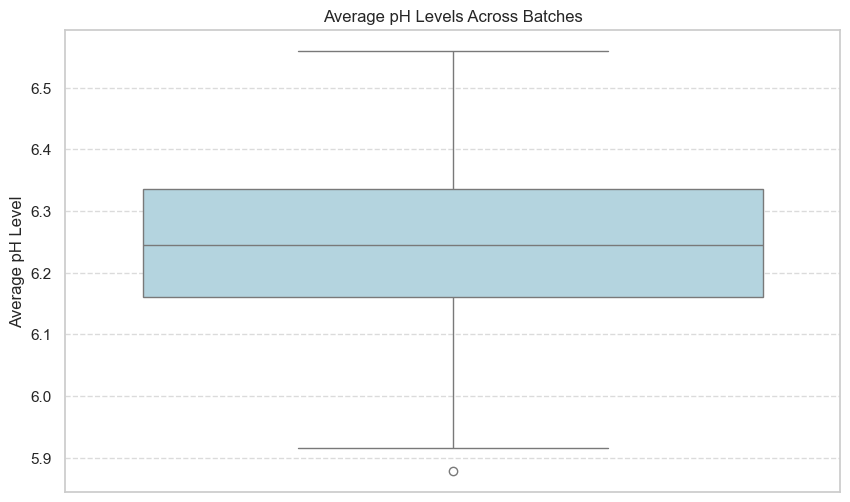

In [80]:
avg_pH_per_batch = cleaned_sensor_data.groupby("Batch_ID")["pH_Level"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.boxplot(data=avg_pH_per_batch, y="pH_Level", color="lightblue")

plt.title("Average pH Levels Across Batches")
plt.ylabel("Average pH Level")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Same as with pressure, very stable readings with not much to point out

# **Feature Creation For Model Training**

Since feeding raw sensor data into the model would likely be detrimental to its performance, we must first create new features that would represent the most important parts of the TDU process while maintaining a format suitable for model training 

In [84]:
#Creating Features df based on batch data and removing start and end times
features_df = cleaned_batch_df.copy()
features_df.drop(["Start_Time", "End_Time"], axis=1, inplace=True)
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Batch_ID                  945 non-null    int64  
 1   Processing_Duration_mins  945 non-null    float64
 2   Batch_Weight_kg           945 non-null    float64
 3   Plastic_Ratio             945 non-null    float64
 4   Biomass_Ratio             945 non-null    float64
 5   Metal_Content             945 non-null    float64
 6   E_Waste_Ratio             945 non-null    float64
 7   Other_Waste_Ratio         945 non-null    float64
 8   Moisture_Content          945 non-null    float64
 9   Batch_Type                945 non-null    object 
dtypes: float64(8), int64(1), object(1)
memory usage: 74.0+ KB


In [85]:
# Retrieving total duration for each batch from the sensor data
total_durations = cleaned_sensor_data.groupby("Batch_ID")["Elapsed_Time"].max().reset_index()
total_durations.rename(columns={"Elapsed_Time": "Total_Duration_Mins"}, inplace=True)

# Merging the total durations with the features DataFrame
features_df = features_df.merge(total_durations, on="Batch_ID", how="left")

# Display the updated features DataFrame
features_df.head()

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0         1                205.282694       954.007669       0.351385   
1         2                210.628787       875.867023       0.276741   
2         3                226.358838      1005.710567       0.312986   
3         4                290.045327      1040.628311       0.293665   
4         5                404.306189      1341.435590       0.198641   

   Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0       0.398791       0.043138       0.041557           0.165130   
1       0.408360       0.045983       0.057500           0.211415   
2       0.379118       0.080260       0.032466           0.195169   
3       0.354917       0.115617       0.076219           0.159583   
4       0.467661       0.069915       0.051911           0.211871   

   Moisture_Content     Batch_Type  Total_Duration_Mins  
0          0.044198  Biomass-Heavy                204.0  
1          0.046327  Biomass-Heavy                209.0  
2          0.044292  Biomass-Heavy                225.0  
3          0.041120  Biomass-Heavy                289.0  
4          0.050573  Biomass-Heavy                403.0

In [86]:
cleaned_sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318050 entries, 0 to 318049
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Batch_ID               318050 non-null  int64  
 1   Elapsed_Time           318050 non-null  float64
 2   Temperature            318050 non-null  float64
 3   Pressure               318050 non-null  float64
 4   Stirring_Speed         318050 non-null  float64
 5   pH_Level               318050 non-null  float64
 6   Waste_Input_Flow_Rate  318050 non-null  float64
 7   Oil_Flow_Rate          318050 non-null  float64
 8   Syngas_Flow_Rate       318050 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 21.8 MB


In [87]:
def calculate_ramp_rates(sensor_data):
    ramp_rates = []
    
    grouped_batches = sensor_data.groupby("Batch_ID")
    
    for batch_id, batch_data in grouped_batches:
        # Ensuring chronological order
        batch_data = batch_data.sort_values(by="Elapsed_Time")
        
        # Identifying the phase split points
        temp_below_300 = batch_data[batch_data["Temperature"] < 300]
        temp_300_to_400 = batch_data[(batch_data["Temperature"] >= 300) & (batch_data["Temperature"] <= 400)]

        # Initial ramp rate calculation (temperature < 300)
        if len(temp_below_300) > 1:
            initial_ramp_rate = (temp_below_300["Temperature"].iloc[-1] - temp_below_300["Temperature"].iloc[0]) / (
                temp_below_300["Elapsed_Time"].iloc[-1] - temp_below_300["Elapsed_Time"].iloc[0])
        else:
            initial_ramp_rate = np.nan  # Setting ramp rate to NaN if insufficient data
        
        # Ramp rate between 300-400 degrees
        if len(temp_300_to_400) > 1:
            ramp_rate_300_to_400 = (temp_300_to_400["Temperature"].iloc[-1] - temp_300_to_400["Temperature"].iloc[0]) / (
                temp_300_to_400["Elapsed_Time"].iloc[-1] - temp_300_to_400["Elapsed_Time"].iloc[0])
        else:
            ramp_rate_300_to_400 = np.nan  # Set ramp rate to NaN if insufficient data
        
        # Storing the ramp rates
        ramp_rates.append({
            "Batch_ID": batch_id,
            "Initial_Ramp_Rate": initial_ramp_rate,
            "Ramp_Rate_300_to_400": ramp_rate_300_to_400
        })

    return pd.DataFrame(ramp_rates)

# Calculate ramp rates and merge into the features DataFrame
ramp_rates_df = calculate_ramp_rates(cleaned_sensor_data)
features_df = pd.merge(features_df, ramp_rates_df, on="Batch_ID")

# Display the result
features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  Total_Duration_Mins  Initial_Ramp_Rate  \
0            0.044198  Biomass-Heavy                204.0           9.006183   
1            0.046327  Biomass-Heavy                209.0           7.178075   
2            0.044292  Biomass-Heavy                225.0           6.578987   
3            0.041120  Biomass-Heavy                289.0           8.633843   
4            0.050573  Biomass-Heavy                403.0           8.112431   
..                ...            ...                  ...                ...   
940          0.040448  Plastic-Heavy                300.0           7.219204   
941          0.051387  Biomass-Heavy                479.0           8.029607   
942          0.043904  Biomass-Heavy                428.0          10.355245   
943          0.038878  Plastic-Heavy                391.0           6.775139   
944          0.054453  Biomass-Heavy                348.0           9.519593   

     Ramp_Rate_300_to_400  
0               10.568364  
1                8.544959  
2               10.231559  
3                9.230402  
4               10.074755  
..                    ...  
940             10.324524  
941             10.831075  
942             11.241375  
943             10.464433  
944             10.320155  

[945 rows x 13 columns]

In [88]:
def calculate_temperature_stats_main_phase(sensor_data):
    temp_stats = []

    # Grouping sensor data by Batch_ID to process each batch individually
    grouped_batches = sensor_data.groupby("Batch_ID")
    
    for batch_id, batch_data in grouped_batches:
        # Filtering data to select temperatures starting from 400 degrees
        main_phase_temps = batch_data[batch_data["Temperature"] >= 400]["Temperature"]
        
        if not main_phase_temps.empty:
            # Calculating standard deviation, average, and maximum temperature, 
            # minimum doesn't make much sense to add as it is unlikely to drop below 400 and we have 400 as a cutoff point
            temp_std = main_phase_temps.std()
            temp_avg = main_phase_temps.mean()
            temp_max = main_phase_temps.max()
        else:
            # If no data exists, assign NaN to avoid errors
            temp_std = temp_avg = temp_min = temp_max = np.nan

        # Storing results
        temp_stats.append({
            "Batch_ID": batch_id,
            "Temperature_STD_Main_Phase": temp_std,
            "Temperature_Avg_Main_Phase": temp_avg,
            "Temperature_Max_Main_Phase": temp_max
        })

    # Returning as DataFrame
    temp_stats_df = pd.DataFrame(temp_stats)
    return temp_stats_df

# Calculating temperature statistics during the main phase
temperature_stats_df = calculate_temperature_stats_main_phase(cleaned_sensor_data)
features_df = pd.merge(features_df, temperature_stats_df, on="Batch_ID")

features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  Total_Duration_Mins  Initial_Ramp_Rate  \
0            0.044198  Biomass-Heavy                204.0           9.006183   
1            0.046327  Biomass-Heavy                209.0           7.178075   
2            0.044292  Biomass-Heavy                225.0           6.578987   
3            0.041120  Biomass-Heavy                289.0           8.633843   
4            0.050573  Biomass-Heavy                403.0           8.112431   
..                ...            ...                  ...                ...   
940          0.040448  Plastic-Heavy                300.0           7.219204   
941          0.051387  Biomass-Heavy                479.0           8.029607   
942          0.043904  Biomass-Heavy                428.0          10.355245   
943          0.038878  Plastic-Heavy                391.0           6.775139   
944          0.054453  Biomass-Heavy                348.0           9.519593   

     Ramp_Rate_300_to_400  Temperature_STD_Main_Phase  \
0               10.568364                   13.059757   
1                8.544959                    9.565602   
2               10.231559                   14.961272   
3                9.230402                    9.290876   
4               10.074755                    8.902440   
..                    ...                         ...   
940             10.324524                   10.585657   
941             10.831075                    9.896434   
942             11.241375                    9.280153   
943             10.464433                    9.335192   
944             10.320155                   10.467384   

     Temperature_Avg_Main_Phase  Temperature_Max_Main_Phase  
0                    487.810408                  511.470320  
1                    456.796387                  476.904769  
2                    495.164409                  514.620814  
3                    455.719877                  484.136588  
4                    449.984598                  471.744130  
..                          ...                         ...  
940                  477.695501                  502.242130  
941                  457.713091                  485.639928  
942                  458.978695                

In [89]:
def calculate_pressure_stats_main_phase(sensor_data):
    pressure_stats = []

    # Grouping sensor data by Batch_ID to process each batch individually
    grouped_batches = sensor_data.groupby("Batch_ID")
    
    for batch_id, batch_data in grouped_batches:
        # Determining the start of the main phase (35% of duration)
        total_duration = len(batch_data)
        main_phase_start_index = int(total_duration * 0.35)
        
        # Selecting pressure readings starting from the main phase
        main_phase_pressure = batch_data.iloc[main_phase_start_index:]["Pressure"]

        # Calculating standard deviation, average, minimum, and maximum pressure during the main phase
        pressure_std = main_phase_pressure.std()
        pressure_avg = main_phase_pressure.mean()
        pressure_min = main_phase_pressure.min()
        pressure_max = main_phase_pressure.max()

        # Storing results
        pressure_stats.append({
            "Batch_ID": batch_id,
            "Pressure_STD_Main_Phase": pressure_std,
            "Pressure_Avg_Main_Phase": pressure_avg,
            "Pressure_Min_Main_Phase": pressure_min,
            "Pressure_Max_Main_Phase": pressure_max
        })

    # Returning as DataFrame
    pressure_stats_df = pd.DataFrame(pressure_stats)
    return pressure_stats_df

# Calculating standard deviation of pressure during the main phase
pressure_std_df = calculate_pressure_stats_main_phase(cleaned_sensor_data)
features_df = pd.merge(features_df, pressure_std_df, on="Batch_ID")

features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  Total_Duration_Mins  Initial_Ramp_Rate  \
0            0.044198  Biomass-Heavy                204.0           9.006183   
1            0.046327  Biomass-Heavy                209.0           7.178075   
2            0.044292  Biomass-Heavy                225.0           6.578987   
3            0.041120  Biomass-Heavy                289.0           8.633843   
4            0.050573  Biomass-Heavy                403.0           8.112431   
..                ...            ...                  ...                ...   
940          0.040448  Plastic-Heavy                300.0           7.219204   
941          0.051387  Biomass-Heavy                479.0           8.029607   
942          0.043904  Biomass-Heavy                428.0          10.355245   
943          0.038878  Plastic-Heavy                391.0           6.775139   
944          0.054453  Biomass-Heavy                348.0           9.519593   

     Ramp_Rate_300_to_400  Temperature_STD_Main_Phase  \
0               10.568364                   13.059757   
1                8.544959                    9.565602   
2               10.231559                   14.961272   
3                9.230402                    9.290876   
4               10.074755                    8.902440   
..                    ...                         ...   
940             10.324524                   10.585657   
941             10.831075                    9.896434   
942             11.241375                    9.280153   
943             10.464433                    9.335192   
944             10.320155                   10.467384   

     Temperature_Avg_Main_Phase  Temperature_Max_Main_Phase  \
0                    487.810408                  511.470320   
1                    456.796387                  476.904769   
2                    495.164409                  514.620814   
3                    455.719877                  484.136588   
4                    449.984598                  471.744130   
..                          ...                         ...   
940                  477.695501                  502.242130   
941                  457.713091                  485.639928   
942                  458.978695       

In [90]:
def calculate_ph_stats_main_phase(sensor_data):
    ph_stats = []

    # Grouping sensor data by Batch_ID to process each batch individually
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Determining the start of the main phase (35% of the processing duration)
        main_phase_start_index = int(len(batch_data) * 0.35)
        
        # Selecting pH readings starting from the main phase
        main_phase_ph = batch_data.iloc[main_phase_start_index:]["pH_Level"]

        if not main_phase_ph.empty:
            # Calculating standard deviation, average, minimum, and maximum pH
            ph_std = main_phase_ph.std()
            ph_avg = main_phase_ph.mean()
            ph_min = main_phase_ph.min()
            ph_max = main_phase_ph.max()
        else:
            # If no data exists, assign NaN to avoid errors
            ph_std = ph_avg = ph_min = ph_max = np.nan

        # Storing results
        ph_stats.append({
            "Batch_ID": batch_id,
            "pH_STD_Main_Phase": ph_std,
            "pH_Avg_Main_Phase": ph_avg,
            "pH_Min_Main_Phase": ph_min,
            "pH_Max_Main_Phase": ph_max
        })

    # Returning as DataFrame
    ph_stats_df = pd.DataFrame(ph_stats)
    return ph_stats_df

# Calculating pH statistics during the main phase
ph_stats_df = calculate_ph_stats_main_phase(cleaned_sensor_data)
features_df = pd.merge(features_df, ph_stats_df, on="Batch_ID")

features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  ...  Temperature_Avg_Main_Phase  \
0            0.044198  Biomass-Heavy  ...                  487.810408   
1            0.046327  Biomass-Heavy  ...                  456.796387   
2            0.044292  Biomass-Heavy  ...                  495.164409   
3            0.041120  Biomass-Heavy  ...                  455.719877   
4            0.050573  Biomass-Heavy  ...                  449.984598   
..                ...            ...  ...                         ...   
940          0.040448  Plastic-Heavy  ...                  477.695501   
941          0.051387  Biomass-Heavy  ...                  457.713091   
942          0.043904  Biomass-Heavy  ...                  458.978695   
943          0.038878  Plastic-Heavy  ...                  446.813046   
944          0.054453  Biomass-Heavy  ...                  475.850644   

     Temperature_Max_Main_Phase  Pressure_STD_Main_Phase  \
0                    511.470320                 0.167470   
1                    476.904769                 0.167119   
2                    514.620814                 0.163271   
3                    484.136588                 0.146964   
4                    471.744130                 0.148048   
..                          ...                      ...   
940                  502.242130                 0.175102   
941                  485.639928                 0.155141   
942                  481.391680                 0.153009   
943                  468.823880                 0.151502   
944                  498.622871                 0.145324   

     Pressure_Avg_Main_Phase  Pressure_Min_Main_Phase  \
0                   3.809719                 3.479063   
1                   3.646598                 3.188221   
2                   3.496281                 3.117144   
3                   3.546270                 3.203651   
4                   3.672393                 3.298005   
..                       ...                      ...   
940                 3.451829                 3.042329   
941                 3.590690                 3.181192   
942                 3.804718                 3.312139   
943                 3.563829                 3.166527   
944                 3.6656

In [91]:
def calculate_stirring_speed_stats_main_phase(sensor_data):
    stirring_speed_stats = []

    # Grouping sensor data by Batch_ID to process each batch individually
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Determining the start of the main phase (35% of the processing duration)
        main_phase_start_index = int(len(batch_data) * 0.35)
        
        # Selecting stirring speed readings starting from the main phase
        main_phase_stirring_speed = batch_data.iloc[main_phase_start_index:]["Stirring_Speed"]

        if not main_phase_stirring_speed.empty:
            # Calculating standard deviation, average, minimum, and maximum stirring speed
            stirring_std = main_phase_stirring_speed.std()
            stirring_avg = main_phase_stirring_speed.mean()
            stirring_min = main_phase_stirring_speed.min()
            stirring_max = main_phase_stirring_speed.max()
        else:
            # If no data exists, assign NaN to avoid errors
            stirring_std = stirring_avg = stirring_min = stirring_max = np.nan

        # Storing results
        stirring_speed_stats.append({
            "Batch_ID": batch_id,
            "Stirring_Speed_STD_Main_Phase": stirring_std,
            "Stirring_Speed_Avg_Main_Phase": stirring_avg,
            "Stirring_Speed_Min_Main_Phase": stirring_min,
            "Stirring_Speed_Max_Main_Phase": stirring_max
        })

    # Returning as DataFrame
    stirring_speed_stats_df = pd.DataFrame(stirring_speed_stats)
    return stirring_speed_stats_df

# Calculating stirring speed statistics during the main phase
stirring_speed_stats_df = calculate_stirring_speed_stats_main_phase(cleaned_sensor_data)
features_df = pd.merge(features_df, stirring_speed_stats_df, on="Batch_ID")

# Displaying the first few rows of the results
features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  ...  Pressure_Min_Main_Phase  \
0            0.044198  Biomass-Heavy  ...                 3.479063   
1            0.046327  Biomass-Heavy  ...                 3.188221   
2            0.044292  Biomass-Heavy  ...                 3.117144   
3            0.041120  Biomass-Heavy  ...                 3.203651   
4            0.050573  Biomass-Heavy  ...                 3.298005   
..                ...            ...  ...                      ...   
940          0.040448  Plastic-Heavy  ...                 3.042329   
941          0.051387  Biomass-Heavy  ...                 3.181192   
942          0.043904  Biomass-Heavy  ...                 3.312139   
943          0.038878  Plastic-Heavy  ...                 3.166527   
944          0.054453  Biomass-Heavy  ...                 3.303506   

     Pressure_Max_Main_Phase  pH_STD_Main_Phase  pH_Avg_Main_Phase  \
0                   4.242424           0.384994           6.284761   
1                   4.218836           0.387725           6.347284   
2                   3.911949           0.381737           6.282511   
3                   3.900595           0.400029           6.290112   
4                   4.320204           0.391499           6.109260   
..                       ...                ...                ...   
940                 4.191779           0.342199           6.442207   
941                 3.994824           0.371513           6.065479   
942                 4.313206           0.350946           6.205280   
943                 3.966364           0.382496           6.392828   
944                 4.011010           0.391477           6.105622   

     pH_Min_Main_Phase  pH_Max_Main_Phase  Stirring_Speed_STD_Main_Phase  \
0             5.456802           7.193714                      15.357799   
1             5.559290           7.374049                      15.001215   
2             5.178862           7.214327                      17.830172   
3             5.212982           7.390611                      17.523275   
4             4.952267           7.073326                      16.518341   
..                 ...                ...                            ...   
940           5.482982           7.27

In [92]:
def calculate_oil_syngas_flow_stats(sensor_data):
    oil_syngas_flow_stats = []

    # Grouping sensor data by Batch_ID to process each batch individually
    grouped_batches = sensor_data.groupby("Batch_ID")

    for batch_id, batch_data in grouped_batches:
        # Identifying the main phase for oil and syngas flow
        oil_main_phase_start_index = batch_data[batch_data["Temperature"] >= 300].index.min()
        syngas_main_phase_start_index = batch_data[batch_data["Temperature"] >= 200].index.min()

        # Selecting oil and syngas flow rates during their respective main phases
        oil_flow_main_phase = batch_data.loc[oil_main_phase_start_index:]["Oil_Flow_Rate"] if oil_main_phase_start_index is not None else []
        syngas_flow_main_phase = batch_data.loc[syngas_main_phase_start_index:]["Syngas_Flow_Rate"] if syngas_main_phase_start_index is not None else []

        # Calculating statistics for oil flow rate
        oil_std = oil_flow_main_phase.std() if not oil_flow_main_phase.empty else np.nan
        oil_avg = oil_flow_main_phase.mean() if not oil_flow_main_phase.empty else np.nan
        oil_min = oil_flow_main_phase.min() if not oil_flow_main_phase.empty else np.nan
        oil_max = oil_flow_main_phase.max() if not oil_flow_main_phase.empty else np.nan

        # Calculating statistics for syngas flow rate
        syngas_std = syngas_flow_main_phase.std() if not syngas_flow_main_phase.empty else np.nan
        syngas_avg = syngas_flow_main_phase.mean() if not syngas_flow_main_phase.empty else np.nan
        syngas_min = syngas_flow_main_phase.min() if not syngas_flow_main_phase.empty else np.nan
        syngas_max = syngas_flow_main_phase.max() if not syngas_flow_main_phase.empty else np.nan

        # Storing results
        oil_syngas_flow_stats.append({
            "Batch_ID": batch_id,
            "Oil_Flow_STD_Main_Phase": oil_std,
            "Oil_Flow_Avg_Main_Phase": oil_avg,
            "Oil_Flow_Min_Main_Phase": oil_min,
            "Oil_Flow_Max_Main_Phase": oil_max,
            "Syngas_Flow_STD_Main_Phase": syngas_std,
            "Syngas_Flow_Avg_Main_Phase": syngas_avg,
            "Syngas_Flow_Min_Main_Phase": syngas_min,
            "Syngas_Flow_Max_Main_Phase": syngas_max
        })

    # Returning as DataFrame
    oil_syngas_flow_stats_df = pd.DataFrame(oil_syngas_flow_stats)
    return oil_syngas_flow_stats_df

# Calculating oil and syngas flow statistics during the main phase
oil_syngas_flow_stats_df = calculate_oil_syngas_flow_stats(cleaned_sensor_data)

features_df = pd.merge(features_df, oil_syngas_flow_stats_df, on="Batch_ID")

features_df

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0           1                205.282694       954.007669       0.351385   
1           2                210.628787       875.867023       0.276741   
2           3                226.358838      1005.710567       0.312986   
3           4                290.045327      1040.628311       0.293665   
4           5                404.306189      1341.435590       0.198641   
..        ...                       ...              ...            ...   
940       996                301.065843      1197.097604       0.371847   
941       997                480.000000      1306.747493       0.214886   
942       998                429.990877      1306.252056       0.316208   
943       999                392.573669      1467.599385       0.402110   
944      1000                349.720406       987.465883       0.206676   

     Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0         0.398791       0.043138       0.041557           0.165130   
1         0.408360       0.045983       0.057500           0.211415   
2         0.379118       0.080260       0.032466           0.195169   
3         0.354917       0.115617       0.076219           0.159583   
4         0.467661       0.069915       0.051911           0.211871   
..             ...            ...            ...                ...   
940       0.349755       0.070942       0.055351           0.152105   
941       0.532943       0.092734       0.052582           0.106855   
942       0.408310       0.102260       0.044517           0.128705   
943       0.326144       0.074016       0.047940           0.149790   
944       0.533612       0.067774       0.009559           0.182379   

     Moisture_Content     Batch_Type  ...  Stirring_Speed_Min_Main_Phase  \
0            0.044198  Biomass-Heavy  ...                     163.717926   
1            0.046327  Biomass-Heavy  ...                     155.430095   
2            0.044292  Biomass-Heavy  ...                     156.738810   
3            0.041120  Biomass-Heavy  ...                     146.691836   
4            0.050573  Biomass-Heavy  ...                     140.738749   
..                ...            ...  ...                            ...   
940          0.040448  Plastic-Heavy  ...                     135.909218   
941          0.051387  Biomass-Heavy  ...                     142.264580   
942          0.043904  Biomass-Heavy  ...                     149.116264   
943          0.038878  Plastic-Heavy  ...                     131.742733   
944          0.054453  Biomass-Heavy  ...                     162.419775   

     Stirring_Speed_Max_Main_Phase  Oil_Flow_STD_Main_Phase  \
0                       237.042547                 0.341673   
1                       236.605602                 0.210346   
2                       246.356442                 0.233882   
3                       245.563501                 0.128127   
4                       243.335605                 0.085437   
..                             ...                      ...   
940                     253.723725                 0.209059   
941                     241.151531                 0.061438   
942                     247.356916                 0.093251   
943                     246.373244                 0.128607   
944                     248.276616                 0.081684   

     Oil_Flow_Avg_Main_Phase  Oil_Flow_Min_Main_Phase  \
0                   1.709447                 0.039628   
1                   1.011758                 0.032245   
2                   1.157813                 0.007737   
3                   0.760547                 0.007257   
4                   0.594140                 0.003003   
..                       ...                      ...   
940                 1.289666                 0.048434   
941                 0.486162                 0.018706   
942                 0.719906                 0.021809   
943        

In [93]:
features_df = pd.merge(features_df, YieldLog, on="Batch_ID")
features_df.head()
#features_df.to_csv("Features.csv", index=False)

Batch_ID  Processing_Duration_mins  Batch_Weight_kg  Plastic_Ratio  \
0         1                205.282694       954.007669       0.351385   
1         2                210.628787       875.867023       0.276741   
2         3                226.358838      1005.710567       0.312986   
3         4                290.045327      1040.628311       0.293665   
4         5                404.306189      1341.435590       0.198641   

   Biomass_Ratio  Metal_Content  E_Waste_Ratio  Other_Waste_Ratio  \
0       0.398791       0.043138       0.041557           0.165130   
1       0.408360       0.045983       0.057500           0.211415   
2       0.379118       0.080260       0.032466           0.195169   
3       0.354917       0.115617       0.076219           0.159583   
4       0.467661       0.069915       0.051911           0.211871   

   Moisture_Content     Batch_Type  ...  Oil_Flow_STD_Main_Phase  \
0          0.044198  Biomass-Heavy  ...                 0.341673   
1          0.046327  Biomass-Heavy  ...                 0.210346   
2          0.044292  Biomass-Heavy  ...                 0.233882   
3          0.041120  Biomass-Heavy  ...                 0.128127   
4          0.050573  Biomass-Heavy  ...                 0.085437   

   Oil_Flow_Avg_Main_Phase  Oil_Flow_Min_Main_Phase  Oil_Flow_Max_Main_Phase  \
0                 1.709447                 0.039628                 1.912594   
1                 1.011758                 0.032245                 1.267347   
2                 1.157813                 0.007737                 1.255849   
3                 0.760547                 0.007257                 0.930389   
4                 0.594140                 0.003003                 0.735256   

   Syngas_Flow_STD_Main_Phase  Syngas_Flow_Avg_Main_Phase  \
0                    0.370327                    1.517356   
1                    0.353702                    1.360088   
2                    0.342414                    1.261505   
3                    0.150970                    0.773606   
4                    0.163954                    0.967585   

   Syngas_Flow_Min_Main_Phase  Syngas_Flow_Max_Main_Phase  Oil_Volume_Liters  \
0                    0.029143                    1.716711         280.051643   
1                    0.025133                    1.665595         164.763444   
2                    0.012197                    1.419465         203.510352   
3                    0.020473                    0.907134         175.142590   
4                    0.013763                    1.132935         186.885345   

   Oil_Purity_Percent  
0           94.188621  
1           93.333601  
2           93.993437  
3           93.221601  
4           91.812728  

[5 rows x 38 columns]

In [94]:
#features_df.to_csv("Features.csv", index=False)
features_df.columns

Index(['Batch_ID', 'Processing_Duration_mins', 'Batch_Weight_kg',
       'Plastic_Ratio', 'Biomass_Ratio', 'Metal_Content', 'E_Waste_Ratio',
       'Other_Waste_Ratio', 'Moisture_Content', 'Batch_Type',
       'Total_Duration_Mins', 'Initial_Ramp_Rate', 'Ramp_Rate_300_to_400',
       'Temperature_STD_Main_Phase', 'Temperature_Avg_Main_Phase',
       'Temperature_Max_Main_Phase', 'Pressure_STD_Main_Phase',
       'Pressure_Avg_Main_Phase', 'Pressure_Min_Main_Phase',
       'Pressure_Max_Main_Phase', 'pH_STD_Main_Phase', 'pH_Avg_Main_Phase',
       'pH_Min_Main_Phase', 'pH_Max_Main_Phase',
       'Stirring_Speed_STD_Main_Phase', 'Stirring_Speed_Avg_Main_Phase',
       'Stirring_Speed_Min_Main_Phase', 'Stirring_Speed_Max_Main_Phase',
       'Oil_Flow_STD_Main_Phase', 'Oil_Flow_Avg_Main_Phase',
       'Oil_Flow_Min_Main_Phase', 'Oil_Flow_Max_Main_Phase',
       'Syngas_Flow_STD_Main_Phase', 'Syngas_Flow_Avg_Main_Phase',
       'Syngas_Flow_Min_Main_Phase', 'Syngas_Flow_Max_Main_Phase',
   

In [95]:
# Changing Batch_Type to categorical so that model can interpret it
features_df["Batch_Type"] = features_df["Batch_Type"].map({"Biomass-Heavy": 0, "Plastic-Heavy": 1}).astype("int64")

In [96]:
#Adding Oil/kg as additional metric  
features_df['Oil_per_kg'] = features_df['Oil_Volume_Liters'] / features_df['Batch_Weight_kg']

## Model Training and Testing

In [98]:
X = features_df.drop(columns=["Oil_Volume_Liters", "Oil_Purity_Percent", "Batch_ID", "Total_Duration_Mins"])  #Excluding targets + duplicate duration
y_volume = features_df["Oil_Volume_Liters"]
y_purity = features_df["Oil_Purity_Percent"]

In [107]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [109]:
X_train, X_test, y_train_volume, y_test_volume, y_train_purity, y_test_purity = train_test_split(
    X_scaled, y_volume, y_purity, test_size=0.2, random_state=42)

X_train, X_val, y_train_volume, y_val_volume, y_train_purity, y_val_purity = train_test_split(
    X_train, y_train_volume, y_train_purity, test_size=0.2, random_state=42)

In [111]:
def evaluate_model(model, X_val, y_val, model_name, target_name):
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f" Model: {model_name} — Prediction {target_name}:")
    print(f"   MAE: {mae:.3f}, MSE: {mse:.3f}, R²: {r2:.3f}\n")
    return mae, mse, r2  

### Two sets of data will be used in this code (and the following ones):

The training set (X_train, y_train_volume, y_train_purity) is used to train models using GridSearchCV with cross-validation (cv=5).
Validation kit (X_val, y_val_volume, y_val_purity) — used to evaluate the best models after selecting hyperparameters with GridSearchCV.

The test dataset in the lower ML stages (X_test, y_test) is not used, since now the main goal is to select the best models

Here, a set of hyperparameters is performed with GridSearchCV (which already uses cross-validation inside X_train), and then the best models are evaluated on the X_val validation set.
The test set is usually used only after the final selection of the model to evaluate its final performance on data that was not involved in the processing and selection of hyperparameters.
Cross-validation reduces the need for a test suite

GridSearchCV uses a split into 5 parts (cv=5), where the model is trained on 4 parts and tested on 1. This already gives a good estimate of performance.
The X_val validation set is used for additional validation of data that did not participate in GridSearchCV.

Usually, the test set is used after optimization is completed to extract information leaks when selecting hyperparameters, which we will do later.

In [114]:
# Model Initialisation 
models = {
    "LightGBM": lgb.LGBMRegressor(verbose=-1, silent=True),  
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", verbosity=0, use_label_encoder=False)
}

# Hyperparameters for grid
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7]
}

best_models = {}  # Dictionary for saving best models

# Model training for separate tasks (yield / purity)
for name, model in models.items():
    print(f"Training {name} for oil yield...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=0)
    grid_search.fit(X_train, y_train_volume)
    
    best_models[f"{name}_Volume"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_volume, name, "Oil Volume")

for name, model in models.items():
    print(f"Training {name} for oil purity...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=0)
    grid_search.fit(X_train, y_train_purity)
    
    best_models[f"{name}_Purity"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_purity, name, "Oil Purity")

print("Training completed")

Training LightGBM for oil yield...
 Model: LightGBM — Prediction Oil Volume:
   MAE: 4.619, MSE: 47.669, R²: 0.993

Training XGBoost for oil yield...
 Model: XGBoost — Prediction Oil Volume:
   MAE: 4.031, MSE: 29.694, R²: 0.996

Training LightGBM for oil purity...
 Model: LightGBM — Prediction Oil Purity:
   MAE: 0.139, MSE: 0.034, R²: 0.981

Training XGBoost for oil purity...
 Model: XGBoost — Prediction Oil Purity:
   MAE: 0.139, MSE: 0.032, R²: 0.982

Training completed


#### The results show that XGBoost outperforms LightGBM in accuracy for both oil volume prediction and oil purity prediction.

Oil Volume:

* XGBoost: MAE = 4.031, MSE = 29.694, R² = 0.996 (the most accurate model).
* LightGBM: MAE = 4.619, MSE = 47.669, R² = 0.993

Oil Purity:

* Both models produce similar results.

Thus, XGBoost is the most accurate model for predicting oil volume, while both models perform equally well for oil purity.

#### Now, it is necessary to analyze which features the model relies on during training:


 Feature importance for Oil Volume (XGBoost) (Top 10 Features):


Feature  Importance
1              Batch_Weight_kg    0.523382
34                  Oil_per_kg    0.449711
27     Oil_Flow_Avg_Main_Phase    0.012365
12  Temperature_Avg_Main_Phase    0.001316
2                Plastic_Ratio    0.001207
26     Oil_Flow_STD_Main_Phase    0.001143
0     Processing_Duration_mins    0.000927
13  Temperature_Max_Main_Phase    0.000813
10        Ramp_Rate_300_to_400    0.000661
29     Oil_Flow_Max_Main_Phase    0.000579

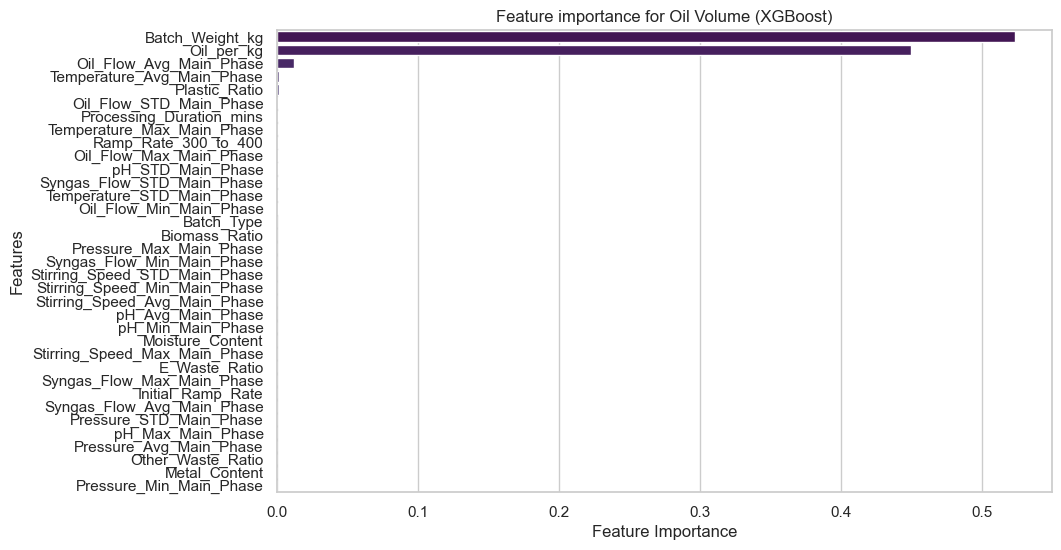


 Feature importance for Oil Purity (XGBoost) (Top 10 Features):


Feature  Importance
3                Biomass_Ratio    0.407476
8                   Batch_Type    0.236848
19           pH_Avg_Main_Phase    0.169135
4                Metal_Content    0.046195
2                Plastic_Ratio    0.045138
6            Other_Waste_Ratio    0.026397
27     Oil_Flow_Avg_Main_Phase    0.025545
13  Temperature_Max_Main_Phase    0.015251
12  Temperature_Avg_Main_Phase    0.011518
34                  Oil_per_kg    0.003689

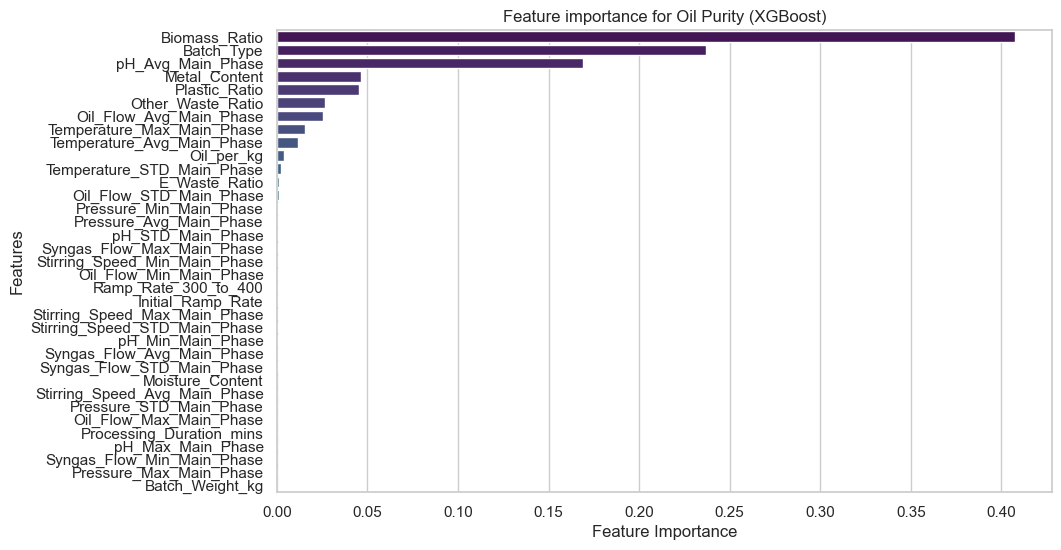


 Feature importance for Oil Volume (LightGBM) (Top 10 Features):


Feature  Importance
34                  Oil_per_kg         761
1              Batch_Weight_kg         633
27     Oil_Flow_Avg_Main_Phase          65
0     Processing_Duration_mins          54
29     Oil_Flow_Max_Main_Phase          33
12  Temperature_Avg_Main_Phase          33
19           pH_Avg_Main_Phase          31
14     Pressure_STD_Main_Phase          31
9            Initial_Ramp_Rate          28
13  Temperature_Max_Main_Phase          26

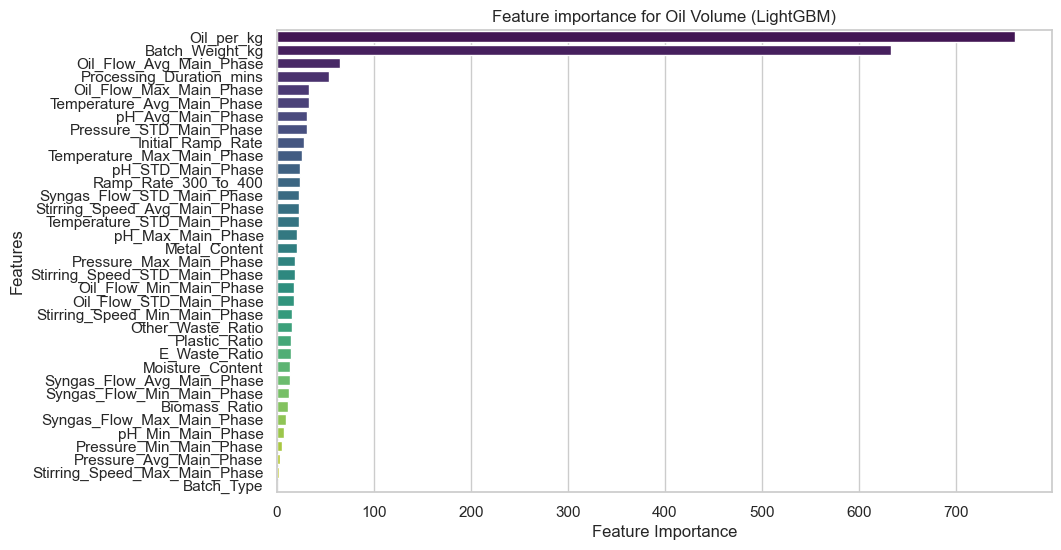


 Feature importance for Oil Purity (LightGBM) (Top 10 Features):


Feature  Importance
2                   Plastic_Ratio         191
6               Other_Waste_Ratio         190
3                   Biomass_Ratio         185
4                   Metal_Content         161
19              pH_Avg_Main_Phase         156
12     Temperature_Avg_Main_Phase         130
5                   E_Waste_Ratio         107
14        Pressure_STD_Main_Phase          78
22  Stirring_Speed_STD_Main_Phase          69
9               Initial_Ramp_Rate          66

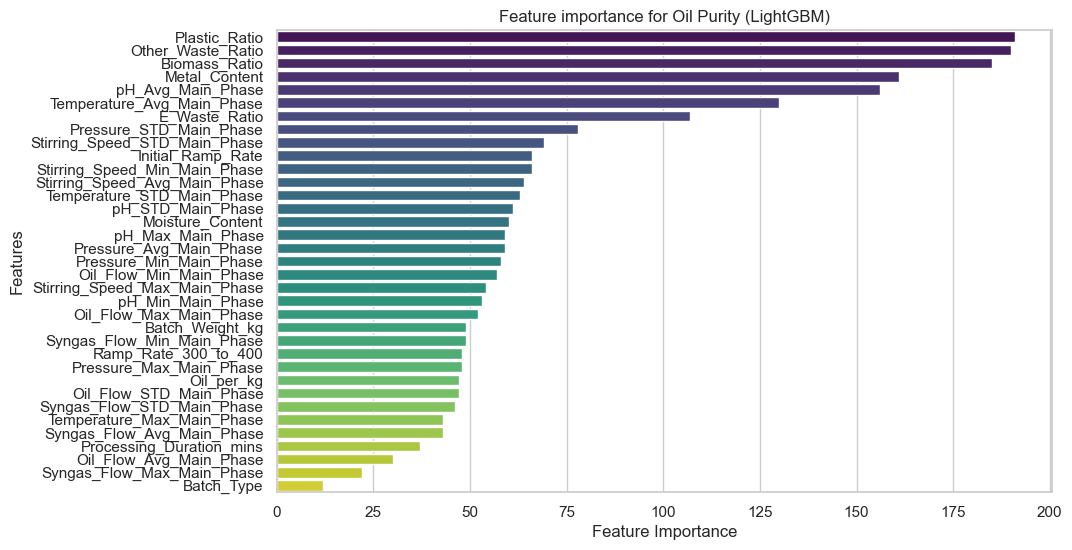

In [116]:
def plot_feature_importance(model, feature_names, title):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Table with top 10 features
    print(f"\n {title} (Top 10 Features):")
    display(feature_importance_df.head(10)) 

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis")
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.show()

# For XGBoost
plot_feature_importance(best_models["XGBoost_Volume"], X.columns, "Feature importance for Oil Volume (XGBoost)")
plot_feature_importance(best_models["XGBoost_Purity"], X.columns, "Feature importance for Oil Purity (XGBoost)")

# For LightGBM
plot_feature_importance(best_models["LightGBM_Volume"], X.columns, "Feature importance for Oil Volume (LightGBM)")
plot_feature_importance(best_models["LightGBM_Purity"], X.columns, "Feature importance for Oil Purity (LightGBM)")

In [117]:
X = features_df.drop(columns=["Oil_Flow_Avg_Main_Phase", "Oil_Flow_STD_Main_Phase", "Oil_Flow_Max_Main_Phase", "Oil_Flow_Min_Main_Phase", "Oil_Volume_Liters", "Oil_per_kg", "Oil_Purity_Percent", "Batch_ID"])  
y_volume = features_df["Oil_per_kg"]
y_purity = features_df["Oil_Purity_Percent"]

Based on the observations, for our further work, the indicator Oil_per_kg is more suitable as the target variable, as it better reflects the final outcome of the process and helps eliminate the influence of indirect features.

Next, we trained the models and realized that during the prediction of oil volume, the models relied more on data related to batch volume, processing duration, and oil production speed rather than sensor data, which is not acceptable for our needs. Therefore, features related to Oil_Flow_* and oil volume (Oil_Volume_Liters) were removed. This was necessary to ensure that the models would focus more on sensor data and process parameters, instead of relying on indirect data that could lead to overfitting.

In [119]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [153]:
X_train, X_test, y_train_volume, y_test_volume, y_train_purity, y_test_purity = train_test_split(
    X_scaled, y_volume, y_purity, test_size=0.2, random_state=42)

X_train, X_val, y_train_volume, y_val_volume, y_train_purity, y_val_purity = train_test_split(
    X_train, y_train_volume, y_train_purity, test_size=0.2, random_state=42)

In [121]:
# Model Initialisation 
models = {
    "LightGBM": lgb.LGBMRegressor(verbose=-1, silent=True),  
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", verbosity=0, use_label_encoder=False)
}

# Hyperparameters for grid
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7]
}

best_models = {}  # Dictionary for saving best models

# Model training for separate tasks (yield / purity)
for name, model in models.items():
    print(f"Training {name} for oil yield...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=0)
    grid_search.fit(X_train, y_train_volume)
    
    best_models[f"{name}_Volume"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_volume, name, "Oil Volume")

for name, model in models.items():
    print(f"Training {name} for oil purity...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_absolute_error", verbose=0)
    grid_search.fit(X_train, y_train_purity)
    
    best_models[f"{name}_Purity"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_purity, name, "Oil Purity")

print("Training completed")

Training LightGBM for oil yield...
 Model: LightGBM — Prediction Oil Volume:
   MAE: 0.022, MSE: 0.001, R²: 0.588

Training XGBoost for oil yield...
 Model: XGBoost — Prediction Oil Volume:
   MAE: 0.023, MSE: 0.001, R²: 0.584

Training LightGBM for oil purity...
 Model: LightGBM — Prediction Oil Purity:
   MAE: 0.130, MSE: 0.031, R²: 0.983

Training XGBoost for oil purity...
 Model: XGBoost — Prediction Oil Purity:
   MAE: 0.129, MSE: 0.030, R²: 0.984

Training completed


In [155]:
# Model Initialisation 
models = {
    "LightGBM": lgb.LGBMRegressor(boosting_type='gbdt', verbose=-1, silent=True),  
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", verbosity=0, use_label_encoder=False, 
                                 tree_method='hist', grow_policy='lossguide', max_leaves=31)
}

# Improved Hyperparameters for grid
param_grid = {
    "n_estimators": [100, 300, 500, 1000],  # More trees for better learning
    "learning_rate": [0.001, 0.01, 0.05, 0.1],  # Finer control over learning rate
    "max_depth": [3, 5, 7, 10],  # Deeper trees for complex patterns
    "min_child_weight": [1, 3, 5],  # Prevents overfitting
    "subsample": [0.6, 0.8, 1.0],  # Use a fraction of the data for each tree
    "colsample_bytree": [0.6, 0.8, 1.0],  # Use a fraction of features per tree
    "gamma": [0, 0.1, 0.3, 0.5],  # Regularization parameter (for XGBoost)
    "reg_alpha": [0, 0.01, 0.1, 1],  # L1 Regularization
    "reg_lambda": [0.1, 1, 10],  # L2 Regularization
}

best_models = {}  # Dictionary for saving best models

# Model training for separate tasks (yield / purity)
for name, model in models.items():
    print(f"Training {name} for oil yield...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0)
    grid_search.fit(X_train, y_train_volume, early_stopping_rounds=50, eval_set=[(X_val, y_val_volume)], verbose=False)
    
    best_models[f"{name}_Volume"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_volume, name, "Oil Volume")

for name, model in models.items():
    print(f"Training {name} for oil purity...")
    
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0)
    grid_search.fit(X_train, y_train_purity, early_stopping_rounds=50, eval_set=[(X_val, y_val_purity)], verbose=False)
    
    best_models[f"{name}_Purity"] = grid_search.best_estimator_  # Saving the model
    evaluate_model(grid_search.best_estimator_, X_val, y_val_purity, name, "Oil Purity")

print("Training completed")



Training LightGBM for oil yield...


ValueError: 
All the 414720 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
414720 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'


In [149]:
print(X_train.shape, y_train_volume.shape)
print(X_val.shape, y_val_volume.shape)

(756, 480, 7) (604,)
(152, 31) (152,)


In [151]:
print(len(X_train), len(y_train_volume))

756 604


### Analysis of Results:
Prediction of Oil_per_kg

#### LightGBM:

* MAE: 0.022
* MSE: 0.001
* R²: 0.588

#### XGBoost:

* MAE: 0.023
* MSE: 0.001
* R²: 0.584

We observe that after feature refinement, a problem has arisen — the low R² value (~0.6) indicates that the model explains only about 60% of the variance in the target variable. This could be due to a lack of significant features after the removal process or the need to further optimize the model parameters.

Prediction of Oil Purity

#### LightGBM:

* MAE: 0.130
* MSE: 0.031
* R²: 0.983

#### XGBoost:

* MAE: 0.129
* MSE: 0.030
* R²: 0.984
  
Here, the models perform steadily and with high accuracy, with R² close to 1, indicating that the removal of features did not impact their ability to predict oil purity.


 Feature importance for Oil Volume (XGBoost) (Top 10 Features):


Feature  Importance
2                Plastic_Ratio    0.172751
13  Temperature_Avg_Main_Phase    0.142618
14  Temperature_Max_Main_Phase    0.091085
6            Other_Waste_Ratio    0.042828
9          Total_Duration_Mins    0.039599
12  Temperature_STD_Main_Phase    0.033699
7             Moisture_Content    0.030355
21           pH_Min_Main_Phase    0.029718
30  Syngas_Flow_Max_Main_Phase    0.028700
29  Syngas_Flow_Min_Main_Phase    0.027962

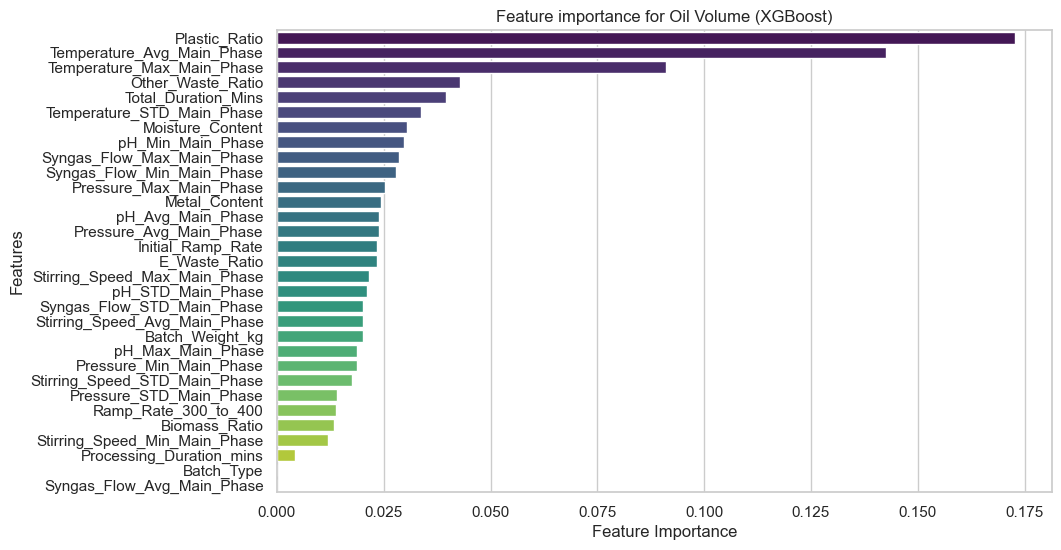


 Feature importance for Oil Purity (XGBoost) (Top 10 Features):


Feature  Importance
8                   Batch_Type    0.417954
3                Biomass_Ratio    0.290529
20           pH_Avg_Main_Phase    0.164073
2                Plastic_Ratio    0.038387
4                Metal_Content    0.030359
6            Other_Waste_Ratio    0.020717
14  Temperature_Max_Main_Phase    0.015164
13  Temperature_Avg_Main_Phase    0.009456
12  Temperature_STD_Main_Phase    0.002105
5                E_Waste_Ratio    0.001252

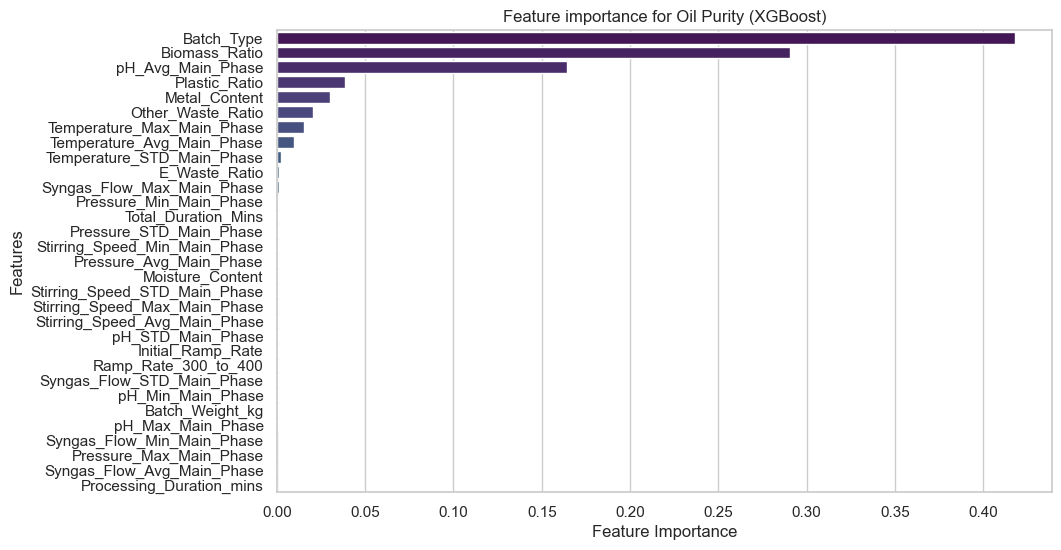


 Feature importance for Oil Volume (LightGBM) (Top 10 Features):


Feature  Importance
2                   Plastic_Ratio         610
13     Temperature_Avg_Main_Phase         552
6               Other_Waste_Ratio         252
4                   Metal_Content         199
14     Temperature_Max_Main_Phase          99
10              Initial_Ramp_Rate          97
26  Stirring_Speed_Max_Main_Phase          93
29     Syngas_Flow_Min_Main_Phase          88
27     Syngas_Flow_STD_Main_Phase          79
23  Stirring_Speed_STD_Main_Phase          79

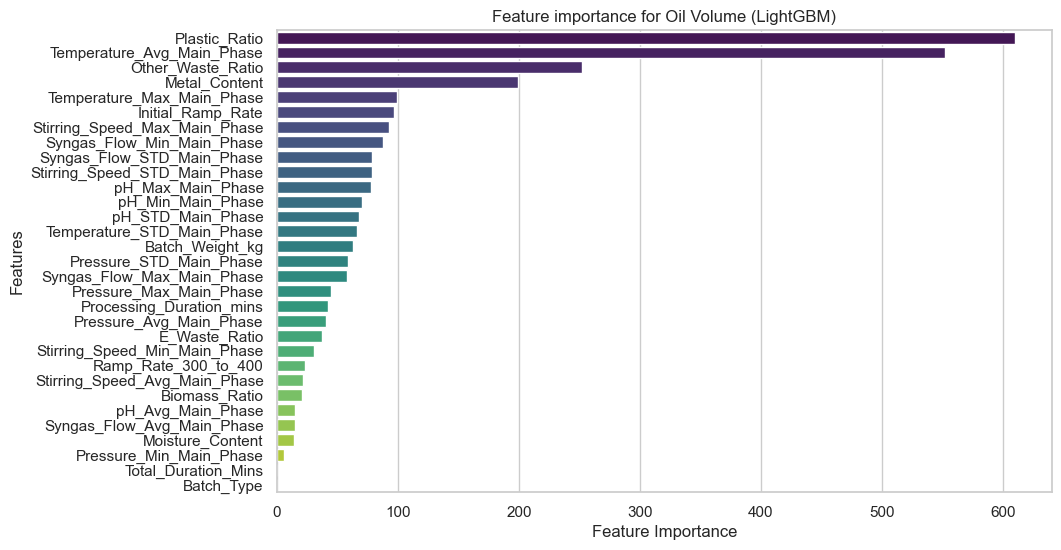


 Feature importance for Oil Purity (LightGBM) (Top 10 Features):


Feature  Importance
2                   Plastic_Ratio         218
3                   Biomass_Ratio         208
6               Other_Waste_Ratio         196
20              pH_Avg_Main_Phase         169
4                   Metal_Content         168
13     Temperature_Avg_Main_Phase         129
27     Syngas_Flow_STD_Main_Phase          94
5                   E_Waste_Ratio          90
22              pH_Max_Main_Phase          89
24  Stirring_Speed_Avg_Main_Phase          86

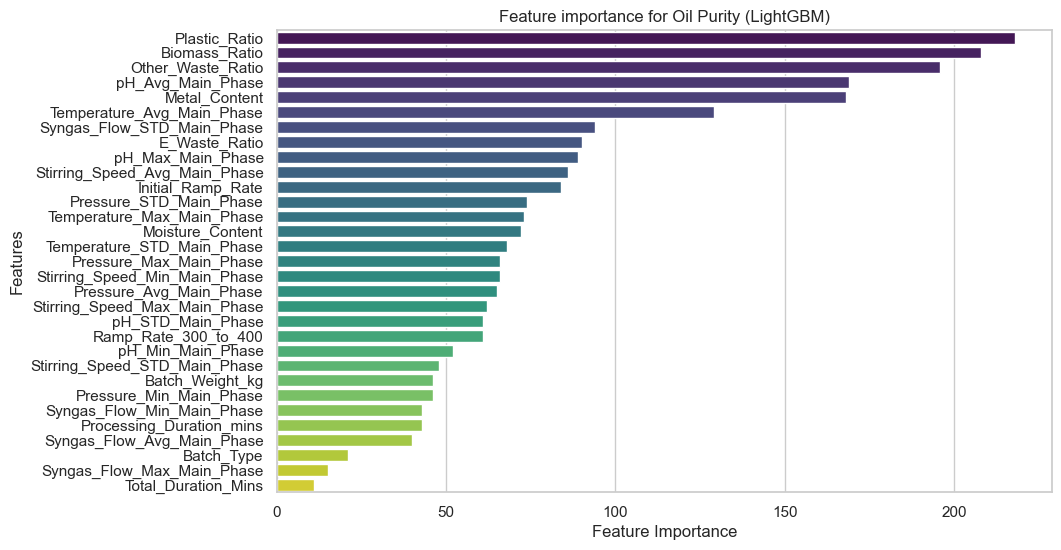

In [123]:
# For XGBoost
plot_feature_importance(best_models["XGBoost_Volume"], X.columns, "Feature importance for Oil Volume (XGBoost)")
plot_feature_importance(best_models["XGBoost_Purity"], X.columns, "Feature importance for Oil Purity (XGBoost)")

# For LightGBM
plot_feature_importance(best_models["LightGBM_Volume"], X.columns, "Feature importance for Oil Volume (LightGBM)")
plot_feature_importance(best_models["LightGBM_Purity"], X.columns, "Feature importance for Oil Purity (LightGBM)")

### Analysis of Feature Importance:
#### For Oil_per_kg
Key features:
Temperature_Max_Main_Phase,
Plastic_Ratio,
Temperature_Avg_Main_Phase

This indicates that the models have started to focus more on the physical parameters of the process (temperature, waste composition), which better aligns with our objective.

#### For Oil Purity
Key features:
Biomass_Ratio,
pH_Avg_Main_Phase,
Batch_Type 

Here, the model correctly identifies biomass and pH level as key factors influencing the purity of the final product.

### To improve the accuracy indicators, first of all, we will work with the parameters of the models:

In [125]:
# Models
models = {
    "LightGBM": lgb.LGBMRegressor(verbose=-1, silent=True),  # Disable output statistics
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", verbosity=0, use_label_encoder=False)  # Disable output
}

# Function for evaluating the model with additional metrics
def evaluate_model(model, X_val, y_val, model_name, target_name):
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)  # Calculate RMSE
    r2 = r2_score(y_val, y_pred)
    
    print(f"🔹 {model_name} — Prediction of {target_name}:")
    print(f"   MAE: {mae:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}\n")
    return mae, mse, rmse, r2

# Define a function for hyperparameter optimization using Optuna for LightGBM
def objective_lightgbm(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 31, 100)
    }

    model = lgb.LGBMRegressor(**param)
    model.fit(X_train, y_train_volume)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val_volume, y_pred)
    return mae

# Define a function for hyperparameter optimization using Optuna for XGBoost
def objective_xgboost(trial):
    param = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    }

    model = xgb.XGBRegressor(objective="reg:squarederror", **param)
    model.fit(X_train, y_train_volume)
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val_volume, y_pred)
    return mae

# Dictionary for storing the best models
best_models = {}

# Training models for oil volume using Optuna
for name, model in models.items():
    print(f"Training {name} for oil volume...")
    
    if name == "LightGBM":
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_lightgbm, n_trials=100)
        best_models[f"{name}_Volume"] = study.best_trial
    elif name == "XGBoost":
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_xgboost, n_trials=100)
        best_models[f"{name}_Volume"] = study.best_trial
    
    print(f"Best parameters for {name}: {study.best_params}")
    print(f"Best value (MAE) for {name}: {study.best_value}")

    # Evaluate the model with optimized parameters
    best_model = model.set_params(**study.best_params)
    best_model.fit(X_train, y_train_volume)
    evaluate_model(best_model, X_val, y_val_volume, name, "Oil Volume")

# Training models for oil purity using Optuna
for name, model in models.items():
    print(f"Training {name} for oil purity...")
    
    if name == "LightGBM":
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_lightgbm, n_trials=100)
        best_models[f"{name}_Purity"] = study.best_trial
    elif name == "XGBoost":
        study = optuna.create_study(direction="minimize")
        study.optimize(objective_xgboost, n_trials=100)
        best_models[f"{name}_Purity"] = study.best_trial
    
    print(f"Best parameters for {name}: {study.best_params}")
    print(f"Best value (MAE) for {name}: {study.best_value}")
    
    # Evaluate the model with optimized parameters
    best_model = model.set_params(**study.best_params)
    best_model.fit(X_train, y_train_purity)
    evaluate_model(best_model, X_val, y_val_purity, name, "Oil Purity")

print("Training completed! You can now analyze feature importance.")

[I 2025-02-03 19:23:59,603] A new study created in memory with name: no-name-7c4cc856-2273-47bc-afb6-58015d29e87a


Training LightGBM for oil volume...


[I 2025-02-03 19:23:59,828] Trial 0 finished with value: 0.023385056249647637 and parameters: {'n_estimators': 200, 'learning_rate': 0.09691660015412062, 'max_depth': 5, 'num_leaves': 69}. Best is trial 0 with value: 0.023385056249647637.
[I 2025-02-03 19:24:00,265] Trial 1 finished with value: 0.022009541010748517 and parameters: {'n_estimators': 500, 'learning_rate': 0.01951831826951479, 'max_depth': 3, 'num_leaves': 59}. Best is trial 1 with value: 0.022009541010748517.
[I 2025-02-03 19:24:01,072] Trial 2 finished with value: 0.023202257574170715 and parameters: {'n_estimators': 500, 'learning_rate': 0.03792809594761102, 'max_depth': 7, 'num_leaves': 75}. Best is trial 1 with value: 0.022009541010748517.
[I 2025-02-03 19:24:01,189] Trial 3 finished with value: 0.02245943804628472 and parameters: {'n_estimators': 100, 'learning_rate': 0.030994434744271663, 'max_depth': 4, 'num_leaves': 98}. Best is trial 1 with value: 0.022009541010748517.
[I 2025-02-03 19:24:01,769] Trial 4 finished

Best parameters for LightGBM: {'n_estimators': 500, 'learning_rate': 0.01926180471153176, 'max_depth': 3, 'num_leaves': 62}
Best value (MAE) for LightGBM: 0.02175169112393096


[I 2025-02-03 19:24:44,628] A new study created in memory with name: no-name-4a5353d3-77a9-4319-bcc9-ee395f96c4af


🔹 LightGBM — Prediction of Oil Volume:
   MAE: 0.022, MSE: 0.001, RMSE: 0.027, R²: 0.596

Training XGBoost for oil volume...


[I 2025-02-03 19:24:45,678] Trial 0 finished with value: 0.023773932623832955 and parameters: {'n_estimators': 200, 'learning_rate': 0.08371217550895836, 'max_depth': 5, 'subsample': 0.6067927946411168, 'colsample_bytree': 0.9555536793429704}. Best is trial 0 with value: 0.023773932623832955.
[I 2025-02-03 19:24:46,190] Trial 1 finished with value: 0.02391471354646459 and parameters: {'n_estimators': 100, 'learning_rate': 0.01668022707039641, 'max_depth': 5, 'subsample': 0.8028207719182912, 'colsample_bytree': 0.6523853362858473}. Best is trial 0 with value: 0.023773932623832955.
[I 2025-02-03 19:24:47,528] Trial 2 finished with value: 0.02264940592212617 and parameters: {'n_estimators': 500, 'learning_rate': 0.07985174387717904, 'max_depth': 6, 'subsample': 0.993824564569264, 'colsample_bytree': 0.6597228571899495}. Best is trial 2 with value: 0.02264940592212617.
[I 2025-02-03 19:24:49,761] Trial 3 finished with value: 0.02292154256321411 and parameters: {'n_estimators': 200, 'learni

Best parameters for XGBoost: {'n_estimators': 200, 'learning_rate': 0.09874153352444992, 'max_depth': 4, 'subsample': 0.9777903903502553, 'colsample_bytree': 0.7859380168494179}
Best value (MAE) for XGBoost: 0.021781766947299275


[I 2025-02-03 19:26:30,385] A new study created in memory with name: no-name-985506a3-2af9-46c3-a4d6-8599e9a49295


🔹 XGBoost — Prediction of Oil Volume:
   MAE: 0.022, MSE: 0.001, RMSE: 0.027, R²: 0.592

Training LightGBM for oil purity...


[I 2025-02-03 19:26:30,972] Trial 0 finished with value: 0.022238741694018575 and parameters: {'n_estimators': 500, 'learning_rate': 0.01765570778419127, 'max_depth': 4, 'num_leaves': 52}. Best is trial 0 with value: 0.022238741694018575.
[I 2025-02-03 19:26:31,526] Trial 1 finished with value: 0.023189303636577185 and parameters: {'n_estimators': 500, 'learning_rate': 0.09432225103465156, 'max_depth': 4, 'num_leaves': 48}. Best is trial 0 with value: 0.022238741694018575.
[I 2025-02-03 19:26:31,717] Trial 2 finished with value: 0.02285737947768184 and parameters: {'n_estimators': 100, 'learning_rate': 0.03118131853076253, 'max_depth': 5, 'num_leaves': 72}. Best is trial 0 with value: 0.022238741694018575.
[I 2025-02-03 19:26:31,928] Trial 3 finished with value: 0.02269403006353869 and parameters: {'n_estimators': 100, 'learning_rate': 0.07373373903559674, 'max_depth': 6, 'num_leaves': 60}. Best is trial 0 with value: 0.022238741694018575.
[I 2025-02-03 19:26:32,922] Trial 4 finished w

Best parameters for LightGBM: {'n_estimators': 200, 'learning_rate': 0.04989243431315796, 'max_depth': 3, 'num_leaves': 43}
Best value (MAE) for LightGBM: 0.021674010056523432
🔹 LightGBM — Prediction of Oil Purity:
   MAE: 0.146, MSE: 0.037, RMSE: 0.192, R²: 0.980

Training XGBoost for oil purity...


[I 2025-02-03 19:26:58,216] Trial 0 finished with value: 0.022839600166528817 and parameters: {'n_estimators': 100, 'learning_rate': 0.04120654760333605, 'max_depth': 5, 'subsample': 0.9664402991673998, 'colsample_bytree': 0.880146980769618}. Best is trial 0 with value: 0.022839600166528817.
[I 2025-02-03 19:26:59,759] Trial 1 finished with value: 0.023184695802953466 and parameters: {'n_estimators': 100, 'learning_rate': 0.025312397156018535, 'max_depth': 7, 'subsample': 0.7621038419965394, 'colsample_bytree': 0.8846557412141494}. Best is trial 0 with value: 0.022839600166528817.
[I 2025-02-03 19:27:00,651] Trial 2 finished with value: 0.02246171252898339 and parameters: {'n_estimators': 500, 'learning_rate': 0.012907966894463142, 'max_depth': 3, 'subsample': 0.6275721095639086, 'colsample_bytree': 0.71533001342307}. Best is trial 2 with value: 0.02246171252898339.
[I 2025-02-03 19:27:00,864] Trial 3 finished with value: 0.02266840517530297 and parameters: {'n_estimators': 100, 'learn

Best parameters for XGBoost: {'n_estimators': 200, 'learning_rate': 0.040725836761704826, 'max_depth': 3, 'subsample': 0.9712033355153742, 'colsample_bytree': 0.9970410225008042}
Best value (MAE) for XGBoost: 0.021800034051488303
🔹 XGBoost — Prediction of Oil Purity:
   MAE: 0.152, MSE: 0.040, RMSE: 0.200, R²: 0.978

Training completed! You can now analyze feature importance.


### 
Analysis of Results Before and After Parameter Optimization:
Oil Volume Prediction:
Before Optimization:

LightGBM:

* MAE: 0.022, MSE: 0.001, R²: 0.588

XGBoost:

* MAE: 0.023, MSE: 0.001, R²: 0.584

After Optimization:

LightGBM:

* MAE: 0.022, MSE: 0.001, RMSE: 0.027, R²: 0.596

XGBoost:

* MAE: 0.022, MSE: 0.001, RMSE: 0.027, R²: 0.592

Key Observations:

The optimization slightly improved the R² score, from ~0.588 to ~0.596 for LightGBM and ~0.584 to ~0.592 for XGBoost.
MAE and MSE remained at similar levels, indicating that the models already had good baseline performance before tuning.
The improvement suggests that further optimization or additional feature engineering may be required to achieve a more significant boost in performance.

Oil Purity Prediction:

Before Optimization:

LightGBM:

* MAE: 0.130, MSE: 0.031, R²: 0.983

XGBoost:

* MAE: 0.129, MSE: 0.030, R²: 0.984

After Optimization:

LightGBM:

* MAE: 0.146, MSE: 0.037, RMSE: 0.192, R²: 0.980

XGBoost:

* MAE: 0.152, MSE: 0.040, RMSE: 0.200, R²: 0.978

Key Observations:

For oil purity, the results slightly worsened after optimization, with MAE and MSE increasing and R² decreasing from ~0.983-0.984 to ~0.978-0.980.
This could indicate overfitting or that the chosen parameter search space led to suboptimal configurations.
Further analysis of the optimization process (e.g., exploring different ranges or using cross-validation to validate the chosen parameters) might be necessary.

Conclusions and Recommendations:

To predict oil purity:

As we can see, after optimization, the models showed worse results, which may indicate that the search area may need to be adjusted or that the basic settings were already close to optimal.

Next, we will need to: work with the range of parameter searches based on the most effective values, analyze the importance of the features and refine additional features that will help the model learn better. Now, due to the limited time, I consider it necessary to switch to a neural network in order to see what results can be learned from it.

### First, we will try a Fully Connected Neural Network based on the Keras library. It is one of the simpler types of neural networks, and we will see what results we can achieve using it.

In [126]:
features = ['Processing_Duration_mins', 'Plastic_Ratio', 'Biomass_Ratio', 
            'Metal_Content', 'E_Waste_Ratio', 'Other_Waste_Ratio', 
            'Moisture_Content', 'Initial_Ramp_Rate', 'Ramp_Rate_300_to_400', 
            'Temperature_STD_Main_Phase', 'Temperature_Avg_Main_Phase', 
            'Temperature_Max_Main_Phase', 'Pressure_STD_Main_Phase', 
            'Pressure_Avg_Main_Phase', 'Pressure_Min_Main_Phase', 
            'Pressure_Max_Main_Phase', 'pH_STD_Main_Phase', 'pH_Avg_Main_Phase', 
            'pH_Min_Main_Phase', 'pH_Max_Main_Phase', 'Stirring_Speed_STD_Main_Phase', 
            'Stirring_Speed_Avg_Main_Phase', 'Stirring_Speed_Min_Main_Phase', 
            'Stirring_Speed_Max_Main_Phase']

target = ['Oil_per_kg']

X = features_df[features].values
y = features_df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),  # Dropout to avoid overfitting
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Single output neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae', tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on test data
evaluation = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss (MSE): {evaluation[0]}")
print(f"Test MAE: {evaluation[1]}")
print(f"Test RMSE: {evaluation[2]}")


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.2064 - mae: 0.3562 - root_mean_squared_error: 0.4453 - val_loss: 0.0115 - val_mae: 0.0847 - val_root_mean_squared_error: 0.1073
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0344 - mae: 0.1432 - root_mean_squared_error: 0.1851 - val_loss: 0.0095 - val_mae: 0.0821 - val_root_mean_squared_error: 0.0976
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0251 - mae: 0.1223 - root_mean_squared_error: 0.1583 - val_loss: 0.0049 - val_mae: 0.0585 - val_root_mean_squared_error: 0.0702
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0168 - mae: 0.1042 - root_mean_squared_error: 0.1294 - val_loss: 0.0059 - val_mae: 0.0654 - val_root_mean_squared_error: 0.0766
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0127 - mae: 0.0898 - root_mean_squared_error: 0.1125 - val_loss: 0.0059 - val_mae: 0.0652 - val_root_mean_squared_error: 0.0769
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

#### Results:

Test Loss (MSE): 0.0010

The mean squared error on the test dataset is 0.001. This is a small value, indicating that the model provides accurate predictions.

Test MAE: 0.0257

The mean absolute error is 0.0257, meaning that, on average, the model's prediction error for Oil_per_kg is 0.0257 units. If the unit scale of Oil_per_kg is small, this is a good result.

Test RMSE: 0.0323

The root mean squared error (RMSE) is 0.0323, which further confirms the low level of prediction errors.

Conclusion:
The model demonstrated a good level of accuracy on the test dataset, with low values for MSE, MAE, and RMSE. This indicates that the model has been trained well and is capable of adequately predicting the Oil_per_kg value.

However, it’s important to note that traditional ML models have shown similarly high accuracy for these metrics. The main challenge remains improving the R² metric, but there is potential for improvement.

#### To compare, we will try another neural network - LSTM. This network works well with time-series data and might be a perfect fit for our task.

In [134]:
def prepare_lstm_input_with_ids(sensor_data, batch_df, target_column='Oil_per_kg', max_timesteps=480):
    sequences = []
    targets = []
    batch_ids = []

    grouped_sensor_data = sensor_data.groupby("Batch_ID")

    for batch_id, group in grouped_sensor_data:
        group = group.sort_values(by='Elapsed_Time')
        sensor_features = group.drop(['Batch_ID', 'Elapsed_Time'], axis=1).values

        # Truncate or pad sequences
        if len(sensor_features) > max_timesteps:
            sensor_features = sensor_features[:max_timesteps]
        sequences.append(sensor_features)

        # Collect the corresponding target and Batch_ID
        target_value = batch_df.loc[batch_df['Batch_ID'] == batch_id, target_column].values[0]
        targets.append(target_value)
        batch_ids.append(batch_id)

    # Pad sequences and convert to arrays
    padded_sequences = pad_sequences(sequences, maxlen=max_timesteps, padding='post', dtype='float32')
    targets = np.array(targets)

    return padded_sequences, targets, batch_ids

# Usage example
X, y, batch_ids = prepare_lstm_input_with_ids(cleaned_sensor_data, features_df)


In [136]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming `X` is the padded sequence data and `y` is the target variable (oil yield per kg)
X, y, batch_ids = prepare_lstm_input_with_ids(cleaned_sensor_data, features_df)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model using Mean Squared Error loss and add R^2 as a custom metric
class R2Metric(tf.keras.metrics.Metric):
    def __init__(self, name='r2', **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.total_ss = self.add_weight(name='total_ss', initializer='zeros')
        self.residual_ss = self.add_weight(name='residual_ss', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        ss_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
        ss_residual = tf.reduce_sum(tf.square(y_true - y_pred))

        self.total_ss.assign_add(ss_total)
        self.residual_ss.assign_add(ss_residual)

    def result(self):
        return 1 - (self.residual_ss / (self.total_ss + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.total_ss.assign(0)
        self.residual_ss.assign(0)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae', R2Metric()])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 509ms/step - loss: 0.7271 - mae: 0.5865 - r2: -13601.5703 - val_loss: 0.0517 - val_mae: 0.2226 - val_r2: -924.0345
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - loss: 0.4644 - mae: 0.4285 - r2: -9106.1533 - val_loss: 0.0326 - val_mae: 0.1734 - val_r2: -578.2503
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 473ms/step - loss: 0.4353 - mae: 0.3890 - r2: -8653.0391 - val_loss: 0.0171 - val_mae: 0.1190 - val_r2: -303.0882
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - loss: 0.3046 - mae: 0.3409 - r2: -5667.6470 - val_loss: 0.0105 - val_mae: 0.0880 - val_r2: -186.0071
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 506ms/step - loss: 0.2168 - mae: 0.2971 - r2: -4004.9880 - val_loss: 0.0125 - val_mae: 0.0982 - val_r2: -222.1138
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - loss: 0.1875 - mae: 0.2733 - r2: -3586.6165 - val_loss: 0.0150 - val_mae: 0.1071 - val_r2: -268.5965
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 464ms/step - l